In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

In [ ]:
#load the dataset
import random
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/arabic_dataset_classifiction.csv'
df1 = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


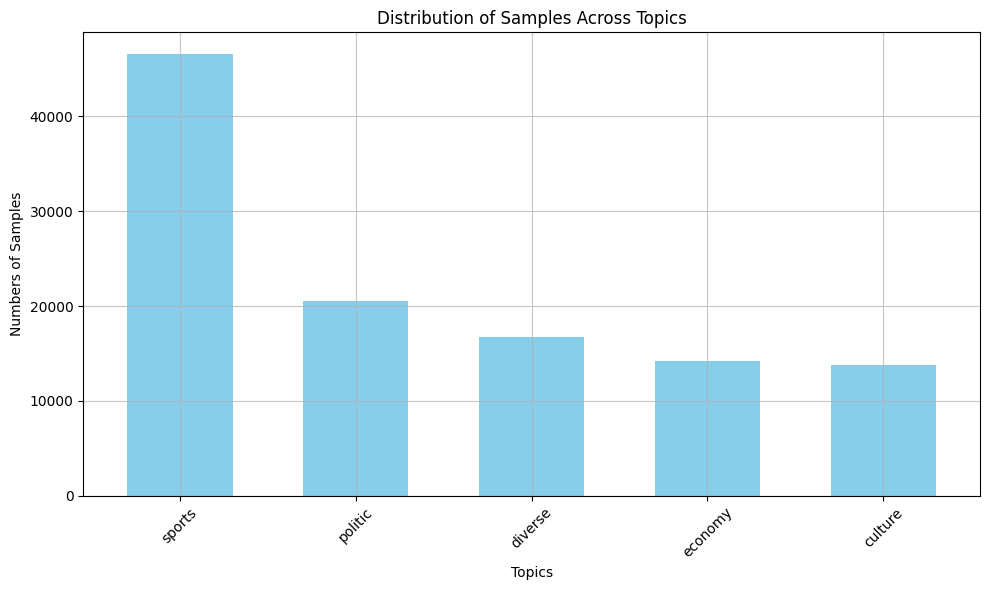

In [ ]:
#plot the distribution of each class in data
topic_mapping = {
    0: 'culture',
    1: 'diverse',
    2: 'economy',
    3: 'politic',
    4: 'sports'
}
df1['targe'] = df1['targe'].map(topic_mapping)

topic_counts = df1['targe'].value_counts()
plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar', color='skyblue', width=0.6)
plt.xlabel('Topics')
plt.ylabel('Numbers of Samples')
plt.title('Distribution of Samples Across Topics')
plt.xticks(rotation=45)
plt.grid(linestyle='-', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
#Take sample from the data
sampled_dfs = []
for target_value in df1['targe'].unique():
    sampled_df = df1[df1['targe'] == target_value].sample(2500, random_state=42)
    sampled_dfs.append(sampled_df)

df_sample = pd.concat(sampled_dfs, ignore_index=True)

sampled_file_path = '/content/drive/MyDrive/sample_data.csv'

df_sample.to_csv(sampled_file_path, index=False)

print(df_sample.head())
df=df_sample

                                                text    targe
0  تحيي الفنانة زهرة هندي حفلا فنيا يوم مارس المق...  culture
1  بلغ عدد المتفرجين الذين حضروا مهرجان البولفار ...  culture
2  أخبارنا المغربية متابعة أطلق نشطاء مغاربة حملة...  culture
3  أكد المشاركون في ندوة دولية انعقدت بمدينة الجد...  culture
4  تدشن الفنانة الشعبية المغربية نجاة اعتابو ابتد...  culture


In [ ]:
#Drop nan value
df.dropna(subset = ["text"], inplace=True)

In [ ]:
#Write functions to clean the data
def remove_diacritics(x):
    arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    x = str(x)
    x = re.sub(arabic_diacritics, '', x)
    return x

def normalize_arabic(x):
    # Convert www.* or https?://* to " "
    x = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', x)
    # Replace #word with word
    x = re.sub(r'#([^\s]+)', r'\1', x)
    x = re.sub("[إأآا]", "ا", x)
    x = re.sub("ى", "ي", x)
    x = re.sub("ؤ", "ء", x)
    x = re.sub("ئ", "ء", x)
    x = re.sub("ة", "ه", x)
    x = re.sub("گ", "ك", x)

    return x

def remove_punctuations(x):
    punctuations_list = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']
    x = str(x)
    translator = str.maketrans(''.join(punctuations_list), ' ' * len(punctuations_list))
    return x.translate(translator)

def remove_repeating_char(x):
    x = str(x)
    return re.sub(r'(.)\1+', r'\1', x)

def remove_english_word_and_numbers(x):
    x = str(x)
    return re.sub(r'[a-zA-Z0-9]+', '', x)

def clean_space(x):
    compiled_re = re.compile(r"\s+")
    return compiled_re.sub(" ", x)

In [ ]:
#Remove the stopwords from the text
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def remove_arabic_stopwords(df, column_name):
    stop_words = set(stopwords.words('arabic'))

    def remove_sw_arabic(text):
        if pd.isnull(text):
            return ''
        words = text.split()
        filtered_words = [word for word in words if word not in stop_words]
        return ' '.join(filtered_words)
    df[column_name] = df[column_name].apply(remove_sw_arabic)
    print(len(stop_words))
    return df

df = remove_arabic_stopwords(df, 'text')
print(df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


701
                                                    text    targe
0      تحيي الفنانة زهرة هندي حفلا فنيا يوم المقبل بم...  culture
1      بلغ عدد المتفرجين حضروا مهرجان البولفار دورته ...  culture
2      أخبارنا المغربية متابعة أطلق نشطاء مغاربة حملة...  culture
3      أكد المشاركون ندوة دولية انعقدت بمدينة الجديدة...  culture
4      تدشن الفنانة الشعبية المغربية نجاة اعتابو ابتد...  culture
...                                                  ...      ...
12495  أوشلة يثور مركب بنجلون بسبب محاولة الحسيمة خطف...   sports
12496  الفريق يفاوض الغازوفي وينتظر رد الوداد بخصوص إ...   sports
12497  أفرج رئيس فتح سيدي بنور لكرة القدم لائحة أعضاء...   sports
12498  حافظ منتخب سلوفاكيا آماله التأهل لـ دور الستة ...   sports
12499  أعلن الاتحاد الأوروبي لكرة القدم يويفا إضافة ج...   sports

[12327 rows x 2 columns]


In [ ]:
import re
def remove_numbers(df, column_name):
    pattern = r'[0-9٠-٩]+'

    def remove_nums(text):
        return re.sub(pattern, '', text)

    df[column_name] = df[column_name].apply(remove_nums)
    return df

df = remove_numbers(df, 'text')

In [ ]:
#Apply all the built-in functions on texts
import re

def clean_text(df):
    df['text'] =  df['text'].apply(remove_diacritics)
    df['text'] =  df['text'].apply(normalize_arabic)
    df['text'] =  df['text'].apply(remove_punctuations)
    df['text'] =  df['text'].apply(remove_repeating_char)
    df['text'] =  df['text'].apply(remove_english_word_and_numbers)
    df['text'] =  df['text'].apply(clean_space)

    return df

df = clean_text(df)

In [ ]:
df['processed_text']=df['text']

In [ ]:
df.head()

,text,targe,processed_text
0,تحي الفنانه زهره هندي حفلا فنيا يوم المقبل بمس...,0,تحي الفنانه زهره هندي حفلا فنيا يوم المقبل بمس...
1,بلغ عد المتفرجين حضروا مهرجان البولفار دورته ا...,0,بلغ عد المتفرجين حضروا مهرجان البولفار دورته ا...
2,اخبارنا المغربيه متابعه اطلق نشطاء مغاربه حمله...,0,اخبارنا المغربيه متابعه اطلق نشطاء مغاربه حمله...
3,اكد المشاركون ندوه دوليه انعقدت بمدينه الجديده...,0,اكد المشاركون ندوه دوليه انعقدت بمدينه الجديده...
4,تدشن الفنانه الشعبيه المغربيه نجاه اعتابو ابتد...,0,تدشن الفنانه الشعبيه المغربيه نجاه اعتابو ابتد...


**LDA model **

In [ ]:
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import gensim.corpora as corpora

tokenized_text = [text.split() for text in df['processed_text']]
id2word = Dictionary(tokenized_text)
corpus = [id2word.doc2bow(text) for text in tokenized_text]

num_topics_values = [4, 6, 8, 10]
coherence_values = []
best_model = None
best_num_topics = None
best_coherence = -1

for num_topics in num_topics_values:
    lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, passes=10, alpha=0.01, eta=0.1, per_word_topics=True, update_every=1)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_text, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

    if coherence_lda > best_coherence:
        best_coherence = coherence_lda
        best_num_topics = num_topics
        best_model = lda_model

print(f"The best parameters are num_topics={best_num_topics} with a coherence score of {best_coherence}.")

The best parameters are num_topics=4 with a coherence score of 0.606220733619071.


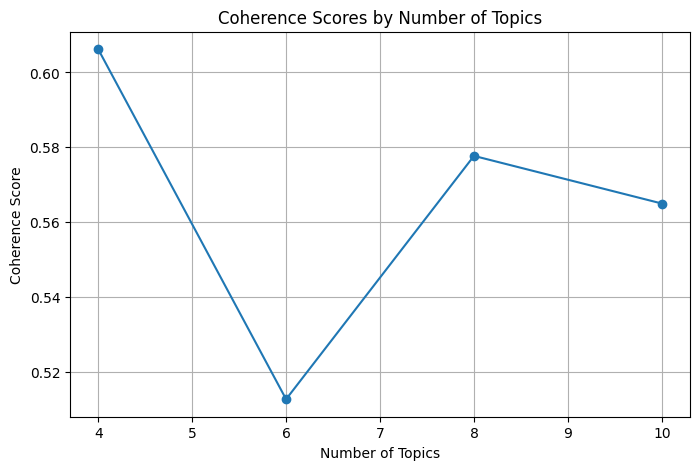

In [ ]:
#plot the Coherence score for each number of topic
plt.figure(figsize=(8, 5))
plt.plot(num_topics_values, coherence_values, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores by Number of Topics")
plt.grid(True)
plt.show()

In [ ]:
#Evaluate the model using this metric
log_likelihood = best_model.log_perplexity(corpus)
perplexity = 2**(-log_likelihood)

print(f"The log likelihood of the LDA model is {log_likelihood}.")
print(f"The perplexity of the LDA model is {perplexity}.")

The log likelihood of the LDA model is -10.453690310220823.
The perplexity of the LDA model is 1402.4078974546255.


In [ ]:
#Load the model in myDrive
import os

save_dir = "/content/drive/My Drive/topic_modelfinal"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model_filename = "best_lda_model.gensim"

local_model_path = os.path.join(save_dir, model_filename)

if best_model:
    best_model.save(local_model_path)

    print(f"Model saved to Google Drive at '{local_model_path}'")
else:
    print("No best model found to save.")

Model saved to Google Drive at '/content/drive/My Drive/topic_modelfinal/best_lda_model.gensim'


In [ ]:
from IPython.display import display, HTML
import pandas as pd

# Create a dictionary to store the top words for each topic
top_words_dict = {f"Topic {i}": [word for word, _ in best_model.show_topic(i, num_words)] for i in range(best_num_topics)}

top_words_df = pd.DataFrame(top_words_dict)

display(HTML(top_words_df.to_html()))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic 0,Topic 1,Topic 2,Topic 3
0,الحكومه,انه,الفريق,المغرب
1,المغربيه,القضاءيه,الرياضي,خلال
2,رءيس,العامه,القدم,المغربيه
3,العام,الشرطه,المباراه,الماءه
4,حزب,عناصر,المنتخب,سنه
5,انه,تم,مباراه,مليون
6,عبد,المتهم,لكره,السنه
7,المغرب,الماضي,الموسم,مليار
8,خلال,الامن,الاعبين,المغربي
9,الحزب,النيابه,الوطني,الدولي


In [ ]:
#Plot the model
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(best_model, corpus, dictionary=best_model.id2word)
save_path = "/content/drive/My Drive/figure_results/lda_visualization.html"
pyLDAvis.save_html(vis, save_path)
print(f"Visualization saved to Google Drive at '{save_path}'")

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Visualization saved to Google Drive at '/content/drive/My Drive/figure_results/lda_visualization.html'


In [ ]:
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.065238 -0.156682       1        1  35.715964
0      0.004468 -0.121487       2        1  31.209374
1     -0.258693  0.093384       3        1  18.934335
3      0.188988  0.184786       4        1  14.140326, topic_info=          Term          Freq         Total Category  logprob  loglift
16725   الفريق   4679.000000   4679.000000  Default  30.0000  30.0000
16723  الرياضي   2810.000000   2810.000000  Default  29.0000  29.0000
413     المغرب  12377.000000  12377.000000  Default  28.0000  28.0000
2171    الماءه   4985.000000   4985.000000  Default  27.0000  27.0000
11013  الحكومه   5910.000000   5910.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
51         انه   1223.256306   8464.975058   Topic4  -5.7058   0.0217
654        عبد   1021.553963   4986.933346   Topic4  -5.8860   0.3706
1312   الوطنيه    951.904909   3881.173545   Topic4  -5.9566   0.5507
468    افريقيا    876.181104   2514.944306   Topic4  -6.0395   0.9017
413     المغرب    907.628691  12377.145720   Topic4  -6.0043  -0.6566

[306 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
0          1  0.530998       »،
0          2  0.075700       »،
0          3  0.347416       »،
0          4  0.046078       »،
12880      1  0.999592  اتفاقيه
...      ...       ...      ...
756        3  0.093430      وفي
756        4  0.157367      وفي
764        1  0.303355     يمكن
764        2  0.662754     يمكن
764        4  0.034250     يمكن

[528 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

**LDA with tfidf**

In [ ]:
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.matutils import Sparse2Corpus
from gensim.corpora import Dictionary
import gensim.corpora as corpora

tokenized_text = [text.split() for text in df['processed_text']]

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.02)
tfidf_vectorized = tfidf_vectorizer.fit_transform(df['processed_text'])

corpus_tfidf = Sparse2Corpus(tfidf_vectorized, documents_columns=False)

id2word_tfidf = Dictionary([list(tfidf_vectorizer.get_feature_names_out())])

num_topics_values = [ 4,6,8,10]
coherence_values = []
best_model = None
best_num_topics = None
best_coherence = -1

for num_topics in num_topics_values:
    lda_model = LdaModel(corpus=corpus_tfidf, id2word=id2word_tfidf, num_topics=num_topics, random_state=42, passes=10, alpha=0.01, eta=0.2, per_word_topics=True)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_text, dictionary=id2word_tfidf, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

    # Update the best model if the current model has higher coherence
    if coherence_lda > best_coherence:
        best_coherence = coherence_lda
        best_num_topics = num_topics
        best_lda_model_with_tfidf = lda_model

print(f"The best parameters are num_topics={best_num_topics} with a coherence score of {best_coherence}.")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The best parameters are num_topics=6 with a coherence score of 0.7178728423923899.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


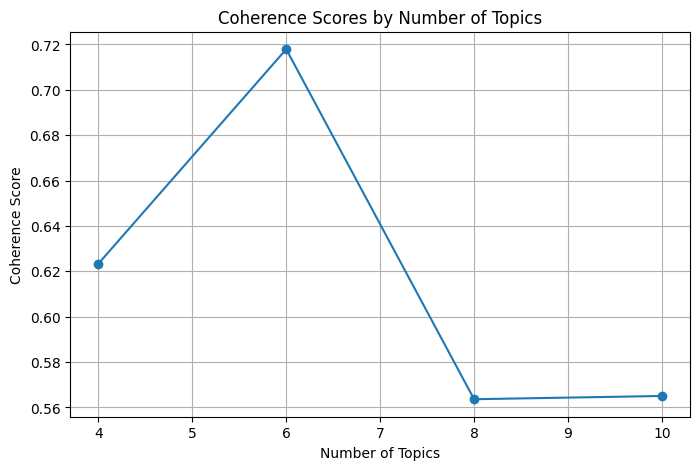

In [ ]:
#plot the Coherence score for each number of topic
plt.figure(figsize=(8, 5))
plt.plot(num_topics_values, coherence_values, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores by Number of Topics")
plt.grid(True)
plt.show()

In [ ]:
#Evaluate the model using this metric
log_likelihood = best_lda_model_with_tfidf.log_perplexity(corpus_tfidf)
perplexity = 2**(-log_likelihood)

print(f"The perplexity of the LDA model is {perplexity}.")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The log likelihood of the LDA model is -7.187724293301843.
The perplexity of the LDA model is 145.78760883437906.


In [ ]:
#Load the model in myDrive
import os

save_dir = "/content/drive/My Drive/topic_modelfinal"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model_filename = "best_lda_model_with_tfidf.gensim"

local_model_path = os.path.join(save_dir, model_filename)

if best_lda_model_with_tfidf:
    best_lda_model_with_tfidf.save(local_model_path)

    print(f"Model saved to Google Drive at '{local_model_path}'")
else:
    print("No best model found to save.")

Model saved to Google Drive at '/content/drive/My Drive/topic_modelfinal/best_lda_model_with_tfidf.gensim'


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from IPython.display import display, HTML
import pandas as pd

# Display the top words for each topic
top_words_df = pd.DataFrame(columns=[f"Topic {i}" for i in range(best_num_topics)])
num_words=10

for i in range(best_num_topics):
    words = best_lda_model_with_tfidf.show_topic(i, num_words)
    top_words_df[f"Topic {i}"] = [word for word, _ in words]

display(HTML(top_words_df.to_html()))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,الفريق,المحكمه,القضاءيه,الحكومه,الفنان,الماءه
1,الرياضي,محكمه,الشرطه,حزب,المغربيه,المغرب
2,المنتخب,الملف,عناصر,المغربيه,المغربي,مليار
3,القدم,التحقيق,العامه,المغرب,برنامج,خلال
4,المباراه,القضيه,النيابه,بنكيران,خلال,مليون
5,مباراه,الاستءناف,المتهم,رءيس,البرنامج,المغربيه
6,لكره,غرفه,الضحيه,لحزب,الفنانه,الشركه
7,الاعبين,الابتداءيه,الامنيه,الحزب,الفيلم,بنسبه
8,الموسم,قاضي,تم,الملك,المهرجان,السنه
9,كاس,المتهمين,الامن,اخبارنا,اغنيه,سنه


In [ ]:
#Plot the model
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(best_lda_model_with_tfidf, corpus_tfidf, dictionary=best_lda_model_with_tfidf.id2word)
save_path = "/content/drive/My Drive/figure_results/lda_tfidf_visualization.html"
pyLDAvis.save_html(vis, save_path)
print(f"Visualization saved to Google Drive at '{save_path}'")
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Visualization saved to Google Drive at '/content/drive/My Drive/figure_results/lda_tfidf_visualization.html'


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.040132 -0.059924       1        1  27.375119
2     -0.157613  0.016095       2        1  20.542015
5      0.060617 -0.097575       3        1  17.680323
0      0.102563  0.139117       4        1  17.388067
4      0.078417 -0.015445       5        1  16.412295
1     -0.124116  0.017732       6        1   0.602182, topic_info=          Term        Freq       Total Category  logprob  loglift
441     المتهم  126.000000  126.000000  Default  30.0000  30.0000
388     الفريق  252.000000  252.000000  Default  29.0000  29.0000
410   القضاءيه  170.000000  170.000000  Default  28.0000  28.0000
427     الماءه  242.000000  242.000000  Default  27.0000  27.0000
449    المحكمه   73.000000   73.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1061    لفاءده    2.159404   54.313238   Topic6  -5.3953   1.8874
410   القضاءيه    2.752639  170.142404   Topic6  -5.1525   0.9883
51        اشهر    2.322333   80.128556   Topic6  -5.3225   1.5713
915         ضد    2.307528   77.548815   Topic6  -5.3289   1.5976
359      العام    2.216497  239.496418   Topic6  -5.3692   0.4298

[311 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
5         1  0.081602  اتحاد
5         2  0.016320  اتحاد
5         3  0.032641  اتحاد
5         4  0.848663  اتحاد
5         5  0.016320  اتحاد
...     ...       ...    ...
1251      1  0.761045   وزير
1251      2  0.015221   وزير
1251      3  0.182651   وزير
1251      4  0.022831   وزير
1251      5  0.022831   وزير

[1101 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 6, 1, 5, 2])

**LDA with Countvector**

In [ ]:
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
from gensim.matutils import Sparse2Corpus
from gensim.corpora import Dictionary
import gensim.corpora as corpora

tokenized_text = [text.split() for text in df['processed_text']]

count_vectorizer = CountVectorizer(max_df=0.95, min_df=0.02)
count_vectorized = count_vectorizer.fit_transform(df['processed_text'])

corpus_count = Sparse2Corpus(count_vectorized, documents_columns=False)

id2word_cv = Dictionary([list(count_vectorizer.get_feature_names_out())])

num_topics_values = [4,6,8,10]
coherence_values = []
best_lda_withCv = None
best_num_topics = None
best_coherence = -1

for num_topics in num_topics_values:
    lda_model = LdaModel(corpus=corpus_count, id2word=id2word_cv, num_topics=num_topics, random_state=42, passes=10, alpha=0.01, eta=0.1, per_word_topics=True)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_text, dictionary=id2word_cv, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

    if coherence_lda > best_coherence:
        best_coherence = coherence_lda
        best_num_topics = num_topics
        best_lda_withCv = lda_model

print(f"The best parameters are num_topics={best_num_topics} with a coherence score of {best_coherence}.")

The best parameters are num_topics=10 with a coherence score of 0.5971910389383639.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


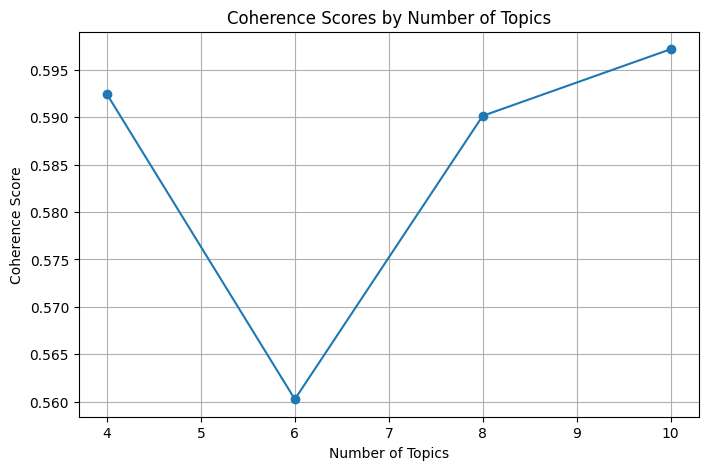

In [ ]:
#plot the Coherence score for each number of topic
plt.figure(figsize=(8, 5))
plt.plot(num_topics_values, coherence_values, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores by Number of Topics")
plt.grid(True)
plt.show()

In [ ]:
#Evaluate the model using this metric
log_likelihood = best_lda_withCv.log_perplexity(corpus_count)
perplexity = 2**(-log_likelihood)

print(f"The perplexity of the Count Vector LDA model is {perplexity}.")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The log likelihood of the Count Vector LDA model is -6.5865342457560025.
The perplexity of the Count Vector LDA model is 96.10464425341262.


In [ ]:
#Load the model in myDrive
import os

save_dir = "/content/drive/My Drive/topic_model"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model_filename = "best_lda_withCv.gensim"

local_model_path = os.path.join(save_dir, model_filename)

if best_lda_withCv:
    best_lda_withCv.save(local_model_path)

    print(f"Model saved to Google Drive at '{local_model_path}'")
else:
    print("No best model found to save.")

Model saved to Google Drive at '/content/drive/My Drive/topic_model/best_lda_withCv.gensim'


In [ ]:
#Display the top 10 words for each topic
from IPython.display import display, HTML
import pandas as pd

num_words = 10
top_words_data = []

for i in range(best_num_topics):
    words = best_lda_withCv.show_topic(i, num_words)
    topic_words = {f"Topic {i}": [word for word, _ in words]}
    top_words_data.append(pd.DataFrame(topic_words))

top_words_df = pd.concat(top_words_data, axis=1)
display(HTML(top_words_df.to_html(index=False)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
المغرب,المتهم,الماءه,خلال,محمد,الفريق,الحكومه,عناصر,المكتب,انه
المغربيه,انه,خلال,مجموعه,المغربيه,الرياضي,حزب,العامه,رءيس,قال
افريقيا,المحكمه,مليون,الفنان,عبد,القدم,رءيس,الشرطه,الجنه,كانت
الدولي,القضاءيه,مليار,الفنيه,المغربي,المباراه,الحزب,الامن,لجنه,انها
الاتحاد,القضيه,المغرب,الجمهور,اله,المنتخب,بنكيران,الامنيه,الانديه,يمكن
العالم,التحقيق,سنه,الدوره,اخبارنا,مباراه,والتنميه,القضاءيه,مصادر,الامر
الافريقيه,الضحيه,السنه,المهرجان,الملك,لكره,لحزب,تم,العام,بشكل
المتحده,الماضي,بنسبه,برنامج,بن,الوطني,العام,النيابه,الصباح,خلال
المغربي,الملف,الماليه,مدينه,اليوم,الموسم,العداله,الملكي,بملعب,رغم
الدول,الاستءناف,المغربيه,مهرجان,يوم,الاعبين,السياسيه,البحث,الوطنيه,يجب


In [ ]:
#Plot the model
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(best_lda_withCv, corpus_count, dictionary=best_lda_withCv.id2word)
save_path = "/content/drive/My Drive/figure_results/lda_CV_visualization.html"
pyLDAvis.save_html(vis, save_path)
print(f"Visualization saved to Google Drive at '{save_path}'")
vis

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Visualization saved to Google Drive at '/content/drive/My Drive/figure_results/lda_CV_visualization.html'


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.003150 -0.050718       1        1  16.785270
2      0.034706 -0.123998       2        1  14.411004
7     -0.168299 -0.041883       3        1  13.390984
9     -0.045718 -0.008163       4        1  11.976436
5      0.064142  0.261597       5        1  10.651975
0      0.204349 -0.006671       6        1   7.364859
3      0.094443 -0.137772       7        1   6.643147
1     -0.250267  0.033497       8        1   6.450441
8     -0.100338  0.034532       9        1   6.439991
4      0.163833  0.039579      10        1   5.885894, topic_info=         Term         Freq        Total Category  logprob  loglift
493    المغرب  9609.000000  9609.000000  Default  30.0000  30.0000
427    الماءه  4508.000000  4508.000000  Default  29.0000  29.0000
495  المغربيه  8091.000000  8091.000000  Default  28.0000  28.0000
388    الفريق  4030.000000  4030.000000  Default  27.0000  27.0000
256   الحكومه  4865.000000  4865.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
364    العربي   355.578054  1327.148883  Topic10  -5.1611   1.5156
165    الاولي   406.106944  2933.324308  Topic10  -5.0282   0.8553
285     الدين   366.990260  1612.480548  Topic10  -5.1295   1.3524
493    المغرب   432.675404  9609.164654  Topic10  -4.9649  -0.2679
840      رءيس   370.745422  4213.173640  Topic10  -5.1194   0.4022

[530 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         1  0.002960  ابتداء
0         2  0.372928  ابتداء
0         6  0.073994  ابتداء
0         7  0.008879  ابتداء
0         9  0.103591  ابتداء
...     ...       ...     ...
1333      6  0.176691     يوم
1333      7  0.024587     يوم
1333      8  0.050007     يوم
1333      9  0.064176     يوم
1333     10  0.299625     يوم

[2090 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 8, 10, 6, 1, 4, 2, 9, 5])

**NMF with countVector**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF

documents = df['processed_text'].tolist()

bow_vectorizer = CountVectorizer(max_df=0.95, min_df=2)
bow = bow_vectorizer.fit_transform(documents)
bow_feature_names = bow_vectorizer.get_feature_names_out()

best_model = None
best_coherence = -1
best_n_components = None
n_components_values = [4, 6, 8, 10]
coherence_values = []
for n_components in n_components_values:
    nmf = NMF(n_components=n_components, init='nndsvda', solver='mu', random_state=42).fit(bow)

    topics_NMF = []
    for index, topic in enumerate(nmf.components_):
        topics_NMF.append([bow_feature_names[i] for i in topic.argsort()[-10:]])

    texts = [text.split() for text in documents]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    cm = CoherenceModel(topics=topics_NMF, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_nmf = cm.get_coherence()
    coherence_values.append(coherence_nmf)

    if coherence_nmf > best_coherence:
        best_coherence = coherence_nmf
        best_NMF_withCv  = nmf
        best_n_components = n_components

print(f"The best NMF model has {best_n_components} topics with a coherence score of {best_coherence}.")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The best NMF model has 8 topics with a coherence score of 0.7099916799394081.


In [ ]:
#Evaluate the model using this metric
from sklearn.metrics.pairwise import cosine_similarity

components= best_NMF_withCv.components_
cos_sim_matrix = cosine_similarity(components)
np.fill_diagonal(cos_sim_matrix, 0)
average_pairwise_similarity = np.sum(cos_sim_matrix) / (best_n_components * (best_n_components - 1))
topic_diversity = 1 - average_pairwise_similarity
print("Topic Diversity:", topic_diversity)

Topic Diversity: 0.8912462429142808


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


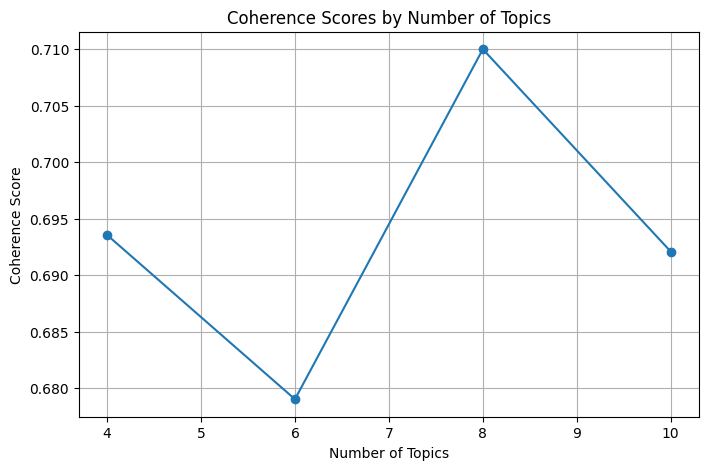

In [ ]:
#plot the Coherence score for each number of topic
plt.figure(figsize=(8, 5))
plt.plot(n_components_values, coherence_values, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores by Number of Topics")
plt.grid(True)
plt.show()

In [ ]:
# Save the NMF model
import os
import joblib

save_dir = "/content/drive/My Drive/topic_model"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

nmf_model_filename = "best_NMF_withCv.joblib"
nmf_local_model_path = os.path.join(save_dir, nmf_model_filename)

if best_NMF_withCv:
    joblib.dump(best_NMF_withCv, nmf_local_model_path)
    print(f"NMF Model saved to Google Drive at '{nmf_local_model_path}'")
else:
    print("No best NMF model found to save.")


NMF Model saved to Google Drive at '/content/drive/My Drive/topic_model/best_NMF_withCv.joblib'


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NMF with TF-IDF


In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import gensim.corpora as corpora

documents = df['processed_text'].tolist()

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

best_NMF_withTfidf = None
best_coherence = -1
best_n_components = None
n_components_values = [4, 6, 8, 10]
coherence_values = []

for n_components in n_components_values:
    nmf = NMF(n_components=n_components, init='nndsvda', solver='mu', random_state=42).fit(tfidf)

    topics_NMF = []
    for index, topic in enumerate(nmf.components_):
        topics_NMF.append([tfidf_feature_names[i] for i in topic.argsort()[-10:]])

    texts = [text.split() for text in documents]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    cm = CoherenceModel(topics=topics_NMF, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_nmf = cm.get_coherence()
    coherence_values.append(coherence_nmf)

    # Update the best model if current model has higher coherence
    if coherence_nmf > best_coherence:
        best_coherence = coherence_nmf
        best_NMF_withTfidf = nmf
        best_n_components = n_components

print(f"The best TF-IDF based NMF model has {best_n_components} topics with a coherence score of {best_coherence}.")

The best TF-IDF based NMF model has 10 topics with a coherence score of 0.8000711043488312.


In [ ]:
#Evaluate the model using this metric
from sklearn.metrics.pairwise import cosine_similarity

components= best_NMF_withTfidf.components_
cos_sim_matrix = cosine_similarity(components)
np.fill_diagonal(cos_sim_matrix, 0)
average_pairwise_similarity = np.sum(cos_sim_matrix) / (best_n_components * (best_n_components - 1))
topic_diversity = 1 - average_pairwise_similarity
print("Topic Diversity:", topic_diversity)

Topic Diversity: 0.8613866438083037


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


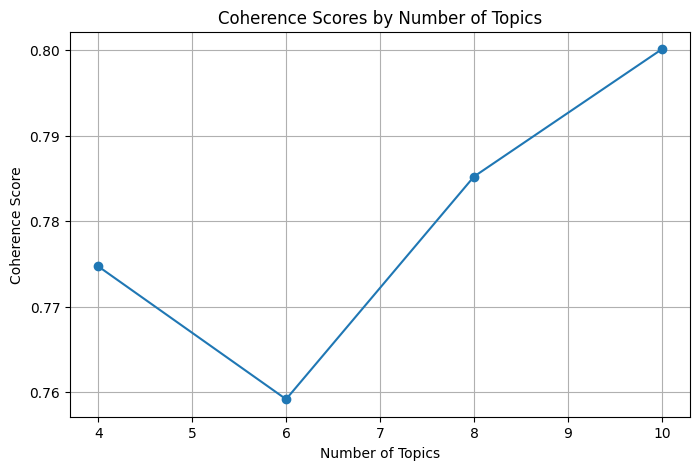

In [ ]:
#plot the Coherence score for each number of topic
plt.figure(figsize=(8, 5))
plt.plot(n_components_values, coherence_values, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores by Number of Topics")
plt.grid(True)
plt.show()

In [ ]:
# save the model
import os
import joblib

save_dir = "/content/drive/My Drive/topic_model"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

nmf_model_filename = "best_NMF_withTfidf.joblib"
nmf_local_model_path = os.path.join(save_dir, nmf_model_filename)

if best_NMF_withTfidf:
    joblib.dump(best_NMF_withTfidf, nmf_local_model_path)
    print(f"NMF Model saved to Google Drive at '{nmf_local_model_path}'")
else:
    print("No best NMF model found to save.")


NMF Model saved to Google Drive at '/content/drive/My Drive/topic_model/best_NMF_withTfidf.joblib'


In [ ]:
num_topics = best_n_components
num_words = 10

feature_names = tfidf_vectorizer.get_feature_names_out()
components = best_NMF_withTfidf.components_

for topic_idx, topic in enumerate(components):
    print(f"Top words for topic {topic_idx}:")

    top_features_indices = topic.argsort()[-num_words:][::-1]
    top_features = [feature_names[i] for i in top_features_indices]
    top_features_weights = [topic[i] for i in top_features_indices]
    # Print each word with its weight in the topic
    for word, weight in zip(top_features, top_features_weights):
        print(f"{word}: {weight:.4f}")
    print("\n")


Top words for topic 0:
الحكومه: 1.3503
حزب: 1.0158
بنكيران: 0.8252
لحزب: 0.7327
الحزب: 0.7265
والتنميه: 0.6294
العداله: 0.6008
رءيس: 0.5317
الاستقلال: 0.4161
الانتخابات: 0.3892


Top words for topic 1:
المتهم: 0.9540
القضاءيه: 0.5813
الضحيه: 0.5377
الشرطه: 0.4541
انه: 0.3450
عناصر: 0.3379
الماضي: 0.3161
المحكمه: 0.3096
الضابطه: 0.3094
التحقيق: 0.3080


Top words for topic 2:
الفريق: 1.3528
الرياضي: 0.7271
الرجاء: 0.6485
الموسم: 0.4876
الاعبين: 0.3992
المباراه: 0.3949
مباراه: 0.3638
الوداد: 0.3600
الاعب: 0.3152
النادي: 0.3079


Top words for topic 3:
الماءه: 1.7311
مليار: 0.7806
بنسبه: 0.6765
السنه: 0.4331
خلال: 0.3892
مليون: 0.3491
سنه: 0.3205
مقابل: 0.2932
الفتره: 0.2733
ارتفاعا: 0.2732


Top words for topic 4:
الفنان: 0.4723
المغربيه: 0.4447
المهرجان: 0.3852
المغربي: 0.3840
البرنامج: 0.3663
خلال: 0.3606
الفيلم: 0.3558
الفنيه: 0.3504
برنامج: 0.3407
اغنيه: 0.3178


Top words for topic 5:
المغرب: 1.2596
المغربيه: 0.4735
الصحراء: 0.3959
الملك: 0.3799
الخارجيه: 0.3568
المتحده: 0.3486
افري

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**LSA**


The best LSA model has 8 topics with a coherence score of 0.4895.


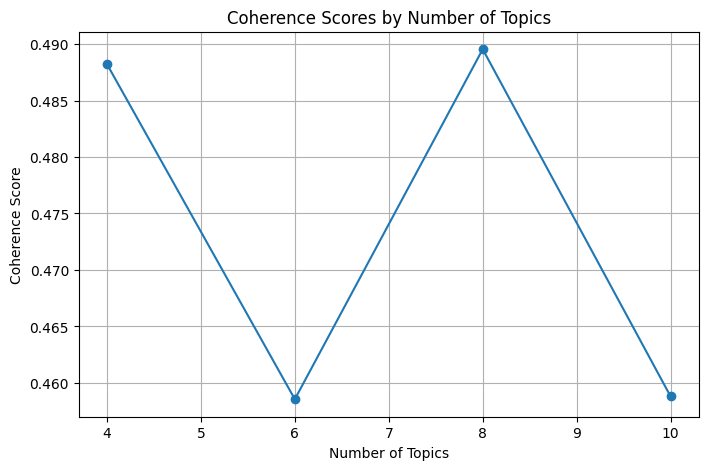

In [ ]:
from gensim.models import LsiModel
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
best_lsa_model = None
best_coherence = -1
best_num_topics = None
n_topics_range = [4, 6, 8, 10]
coherence_scores = []

for num_topics in n_topics_range:
    lsa_model = LsiModel(corpus, num_topics=num_topics, id2word=dictionary)

    topics_LSA = []
    for idx in range(num_topics):
        topic_terms = [term for term, _ in lsa_model.show_topic(idx)]
        topics_LSA.append(topic_terms)

    cm = CoherenceModel(topics=topics_LSA, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lsa = cm.get_coherence()
    coherence_scores.append(coherence_lsa)

    if coherence_lsa > best_coherence:
        best_coherence = coherence_lsa
        best_lsa_model = lsa_model
        best_num_topics = num_topics

print(f'\nThe best LSA model has {best_num_topics} topics with a coherence score of {best_coherence:.4f}.')
#plot the Coherence score for each number of topic
plt.figure(figsize=(8, 5))
plt.plot(n_topics_range, coherence_scores, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores by Number of Topics")
plt.grid(True)
plt.show()


In [ ]:
#Load the model in myDrive
lsa_model_path = "/content/drive/My Drive/topic_model/best_lsa_model.joblib"
joblib.dump(best_lsa_model, lsa_model_path)
print(f'Saved the best LSA model at: {lsa_model_path}')

Saved the best LSA model at: /content/drive/My Drive/topic_model/best_lsa_model.joblib


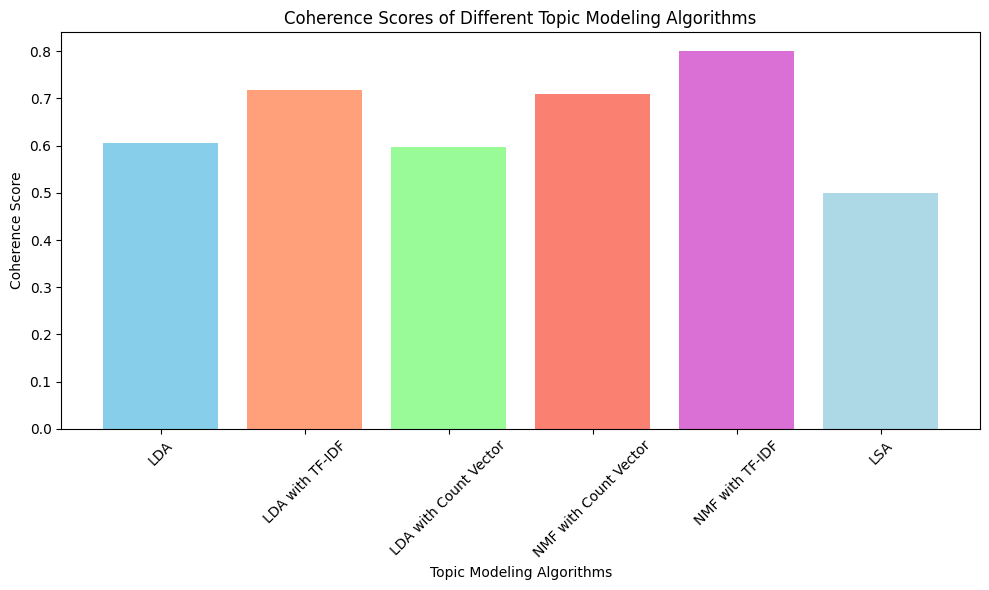

In [ ]:
#Plot the Coherence Scores of Different Topic Modeling Algorithms
import matplotlib.pyplot as plt

algorithms = ['LDA', 'LDA with TF-IDF', 'LDA with Count Vector', 'NMF with Count Vector', 'NMF with TF-IDF', 'LSA']
coherence_scores = [0.606220733619071, 0.7178724977198234, 0.5971910389383639, 0.7098930315433343, 0.8001316755716502, 0.4999]

colors = ['#87CEEB', '#FFA07A', '#98FB98', '#FA8072', '#DA70D6', '#ADD8E6']


plt.figure(figsize=(10, 6))
plt.bar(algorithms, coherence_scores, color=colors)
plt.xlabel('Topic Modeling Algorithms')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores of Different Topic Modeling Algorithms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Load the best_lda_model
from gensim.models.ldamodel import LdaModel
lda_model_path = '/content/drive/MyDrive/topic_model/best_lda_model.gensim'
lda_model = LdaModel.load(lda_model_path)

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import gensim.corpora as corpora

tokenized_text = [text.split() for text in df['processed_text']]
id2word = Dictionary(tokenized_text)
corpus = [id2word.doc2bow(text) for text in tokenized_text]


In [ ]:
# Sample 10 documents from df
sample_data = df.sample(n=5)
#5,
for i, doc in sample_data.iterrows():
    # Preprocess the document
    tokenized_doc = doc['processed_text'].split()
    bow_doc = id2word.doc2bow(tokenized_doc)

    # Get the topic distribution for the document
    doc_topics = lda_model.get_document_topics(bow_doc)

    print(f"Document {i+1} Topics:")
    for topic in doc_topics:
        print(f"Topic {topic[0]}: {topic[1]*100:.2f}%")


Document 1640 Topics:
Topic 0: 22.53%
Topic 2: 63.92%
Topic 3: 13.55%
Document 1440 Topics:
Topic 0: 1.63%
Topic 1: 4.63%
Topic 2: 83.15%
Topic 3: 10.59%
Document 11154 Topics:
Topic 2: 10.26%
Topic 3: 89.71%
Document 8476 Topics:
Topic 0: 57.65%
Topic 1: 28.21%
Topic 2: 14.13%
Document 8025 Topics:
Topic 0: 89.28%
Topic 1: 5.76%
Topic 3: 4.94%


In [ ]:
sample_data['processed_text'].iloc[4]

'اخبارنا المغربيه المنتظر تعيش مفاوضات تشكيل التحالف الحكومي مطبا ثانيا سيفصل حزبي العداله والتنميه التجمع الوطني لاحرار قالت صحيفه الاحداث المغربيه الخلاف نشب المره بشكل مباشر رءيس الحكومه المعين وبين عزيز اخنوش رءيس التجمع المنتخب اسبوع يرغب بنكيران مفاوضه التجمع الوطني لاحرا والاتحاد الدستوري بشكل منفرد حزب الحمامه يفاوض المصباح بمعيه الحصان ويبدو البحث مواقع موازين القوي المفاوضات بدات تظهر التجمع الاتحاد الدستوري جه وبين العداله والتنميه الاستقلال التقدم والاشتراكيه جه ثانيه يظهر حزب اخنوش يريد بتاتا استفراد حزب بنكيران بتوزيع المناصب مقاس الحكومه'

In [ ]:
topic_id = 0
# Get the topic
topic = lda_model.show_topic(topic_id)
print(f"Topic {topic_id}:")

# Print each word and its weight in the topic
for word, weight in topic:
    print(f"{word}: {weight*100:.2f}%")

Topic 0:
الحكومه: 0.65%
رءيس: 0.48%
العام: 0.45%
حزب: 0.41%
المغربيه: 0.41%
انه: 0.39%
عبد: 0.36%
الحزب: 0.28%
بنكيران: 0.26%
العداله: 0.25%


In [ ]:
topic_id = 7
# Get the topic
topic = lda_model.show_topic(topic_id)
print(f"Topic {topic_id}:")

# Print each word and its weight in the topic
for word, weight in topic:
    print(f"{word}: {weight*100:.2f}%")
sample_data['processed_text'].iloc[4]

Topic 7:
انه: 0.52%
الماضي: 0.42%
القضاءيه: 0.41%
المتهم: 0.35%
عناصر: 0.34%
الملكي: 0.33%
مصادر: 0.33%
الشرطه: 0.33%
العامه: 0.29%
تم: 0.27%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'لقي شخص يبلغ العمر حوالي عاما ويتحدر اكنول بتازه مصرعه غرقا بشاطء الطايث باقليم الحسيمه ظهر الاثنين يسبح وقال مصدر مطلع الضحيه اختفي الانظار دقاءق دخوله الماء مضيفا رداءه احوال الطقس وارتفاع الامواج حالا انقاذه ظل يصارع الحياه تجرفه التيارات البحريه بعيدا وانتشلت جثه الضحيه البحر ونقلت متن سياره لنقل الاموات مستودع الاموات بالمستشفي الجهوي لحسيمه الوقت حلت عناصر الدرك الملكي بالمكان لفتح تحقيق الحادث صعيد اخر افاد مصدر مطلع شخصا تعرض لاصابه وصفت بالبالغه راسه اليوم نفسه بشاطء كالابونيطا بالحسيمه واكد المصدر ذاته الضحيه قفز اعلي جبل يطل الشاطء وحين حاول الغطس تلاعبت الامواج فارتطم راسه بالصخور الموجوده الجه اليمني الشاطء ذاته وتم اسعاف المعني بالامر طرف المصطافين تحل بالمكان عناصر الوقايه المدنيه نقلته وجه السرعه قسم المستعجلات بالمستشفي ذاته ولم يستبعد المصدر نفسه امكانيه نقل المواطن المستشفي الجامعي بفاس نظرا لخطوره الاصابه تعرض راسه جمال الفكيكي الحسيمه'

In [ ]:
# Load the best_lda_model_with_tfidf model
from gensim.models.ldamodel import LdaModel
lda_model_path = '/content/drive/MyDrive/topic_model/best_lda_model_with_tfidf.gensim'
lda_model_tfidf = LdaModel.load(lda_model_path)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora import Dictionary
import gensim.corpora as corpora
from gensim.matutils import Sparse2Corpus

tokenized_text = [text.split() for text in df['processed_text']]
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.02)
tfidf_vectorized = tfidf_vectorizer.fit_transform(df['processed_text'])
corpus_tfidf = Sparse2Corpus(tfidf_vectorized, documents_columns=False)
id2word_tfidf = Dictionary([list(tfidf_vectorizer.get_feature_names_out())])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
sample_data = df.sample(n=5)

for i, doc in sample_data.iterrows():
    # Preprocess the document
    tokenized_doc = doc['processed_text'].split()
    bow_doc = id2word_tfidf.doc2bow(tokenized_doc)

    # Get the topic distribution for the document
    doc_topics = lda_model_tfidf.get_document_topics(bow_doc)

    print(f"Document {i+1} Topics:")
    for topic in doc_topics:
        print(f"Topic {topic[0]}: {topic[1]*100:.2f}%")


Document 5428 Topics:
Topic 5: 99.95%
Document 2914 Topics:
Topic 2: 99.78%
Document 4564 Topics:
Topic 1: 35.71%
Topic 2: 64.01%
Document 9510 Topics:
Topic 3: 99.86%
Document 11607 Topics:
Topic 0: 91.25%
Topic 4: 8.74%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(sample_data['processed_text'].iloc[3])

اخبارنا المغربيه علاء المصطفاوي استغل الامين العام لحزب الاستقلال حميد احتفالات فاتح ليوجه رصاصاته المعتاده بنكيران وزراء حكومته وذلك مهرجان خطابي وسط العاصمه العلميه فاس صريح كلامه اعتبر الحكومه الحاليه تقم بجعل ثلثي المغاربه عتبه الفقر وذلك وفقا لاحصاءياتها الرسميه قال الحقاوي وحكومه عبد الاله بنكيران ادخلوا ثلثي المغاربه عتبه الفقر وان ملاين بطاقه راميد الموزعه تخص ملاين مغربي كلهم يقل دخلهم دراهم اليوم وهذه كارثه اجتماعيه يقل دخلهم درهما اليوم فعدهم اكبر وحذر بنكيران غليان شعبي مسبوق لكون المغاربه حسبه ينالوا الحكومه الزلط والحكره وتزايد وفيات الامهات والاطفال والزياده الاسعار


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topic_id = 3
topic = lda_model_tfidf.show_topic(topic_id)
print(f"Topic {topic_id}:")

for word, weight in topic:
    print(f"{word}: {weight*100:.2f}%")

Topic 3:
الحكومه: 1.10%
حزب: 0.79%
المغربيه: 0.75%
المغرب: 0.70%
بنكيران: 0.65%
رءيس: 0.62%
لحزب: 0.59%
الحزب: 0.58%
الملك: 0.53%
اخبارنا: 0.52%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(sample_data['processed_text'].iloc[2])

اجلت المحكمه الابتداءيه بمراكش محاكمه عون سلطه برتبه شيخ حضري متابع بتهمه منح شهاده عزوبه لرجل متزوج وذلك لمنح الفرصه لمحامي لاعداد مرافعته وتعود تفاصيل القضيه سنه ساعد عون السلطه شخصا متزوجا الحصول شهاده العزوبه مقابل


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topic_ids = [1, 2]

for topic_id in topic_ids:
    topic = lda_model.show_topic(topic_id)
    print(f"Topic {topic_id}:")
    for word, weight in topic:
        print(f"{word}: {weight*100:.2f}%")

Topic 1:
المحكمه: 3.72%
محكمه: 1.99%
الملف: 1.59%
التحقيق: 1.50%
القضيه: 1.43%
الاستءناف: 1.36%
غرفه: 1.28%
الابتداءيه: 1.28%
قاضي: 1.24%
المتهمين: 1.18%
Topic 2:
القضاءيه: 0.96%
الشرطه: 0.93%
عناصر: 0.91%
العامه: 0.85%
النيابه: 0.78%
المتهم: 0.73%
الضحيه: 0.71%
الامنيه: 0.68%
تم: 0.62%
الامن: 0.60%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Load the best_lda_withCv model
from gensim.models.ldamodel import LdaModel
lda_model_path = '/content/drive/MyDrive/topic_model/best_lda_withCv.gensim'
lda_model_Cv = LdaModel.load(lda_model_path)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(max_df=0.95, min_df=0.02)
count_vectorized = count_vectorizer.fit_transform(df['processed_text'])
corpus_count = Sparse2Corpus(count_vectorized, documents_columns=False)
id2word_cv = Dictionary([list(count_vectorizer.get_feature_names_out())])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
sample_data = df.sample(n=5)

for i, doc in sample_data.iterrows():
    tokenized_doc = doc['processed_text'].split()
    bow_doc = id2word_cv.doc2bow(tokenized_doc)

    doc_topics = lda_model_Cv.get_document_topics(bow_doc)
    print(f"Document {i+1} Topics:")
    for topic in doc_topics:
        print(f"Topic {topic[0]}: {topic[1]*100:.2f}%")


Document 9701 Topics:
Topic 1: 26.04%
Topic 3: 4.88%
Topic 4: 14.95%
Topic 5: 54.12%
Document 6065 Topics:
Topic 0: 76.95%
Topic 4: 22.98%
Document 754 Topics:
Topic 4: 99.81%
Document 7025 Topics:
Topic 1: 8.95%
Topic 2: 79.77%
Topic 5: 11.19%
Document 1829 Topics:
Topic 1: 4.53%
Topic 2: 20.10%
Topic 4: 75.34%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(sample_data['processed_text'].iloc[1])

قر مدرب الوحده الاماراتي السابق المكسيكي خافير اغيري السفر ابوظبي لتشجيع فريق باتشوكا بطل افريقيا الوداد البيضاوي المباراه جري بينهما اليوم السبت ضمن منافسات كاس العالم لانديه واجري المدرب السابق لعد الانديه الاسبانيه والخليجيه حوارا وكاله الانباء الفرنسيه لحظه وصوله العاصمه الاماراتيه ابوظبي لدعم باتشوكا الوداد وقال اغيري توقعاته المباراه الاولي الوداد الاهم اعتقد باتشوكا قادر تقديم مباراه كبيره غريميو حال تاهله لانه لعب ضد الفرق البرازيليه والارجنتينيه ويعرفها جيدا ، المنافس المغربي مختلف تماما واضاف كامل احترامي لغريميو مباراه نصف النهاءي قلقني قلقي المباراه الاولي الفريق المغربي نعلم عنه اشياء كثيره رغم مدرب باتشوكا بدراسته جيدا ، انهي كلامه الوداد مءكدا تخطينا المباراه بنجاح اعتقد طريق باتشوكا سيكون عبدا المباراه النهاءيه


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topic_ids = [0,4]

for topic_id in topic_ids:
    topic = lda_model.show_topic(topic_id)
    print(f"Topic {topic_id}:")
    for word, weight in topic:
        print(f"{word}: {weight*100:.2f}%")

Topic 0:
الفريق: 2.69%
الرياضي: 1.65%
القدم: 1.43%
المباراه: 1.34%
المنتخب: 1.29%
مباراه: 1.14%
الوطني: 1.00%
لكره: 1.00%
الموسم: 0.99%
الاعبين: 0.95%
Topic 4:
المغربي: 1.55%
المغربيه: 1.36%
خلال: 1.21%
الملعب: 1.15%
المغرب: 1.05%
العالم: 1.01%
انه: 0.96%
الانديه: 0.96%
العربيه: 0.73%
كانت: 0.70%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Load the best_NMF_withCv model
import joblib
nmf_local_model_path="/content/drive/My Drive/topic_model/best_NMF_withCv.joblib"
loaded_nmf_model = joblib.load(nmf_local_model_path)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.matutils import Sparse2Corpus
from gensim.corpora import Dictionary
import gensim.corpora as corpora
from gensim.models import CoherenceModel

documents = df['processed_text'].tolist()

tokenized_text = [text.split() for text in df['processed_text']]
bow_vectorizer = CountVectorizer(max_df=0.95, min_df=2)
bow = bow_vectorizer.fit_transform(documents)
bow_feature_names = bow_vectorizer.get_feature_names_out()

n_components = loaded_nmf_model.components_.shape[0]

topics = []
for i in range(n_components):
    topic = [bow_feature_names[i] for i in loaded_nmf_model.components_[i].argsort()[:-11:-1]]
    topics.append(topic)

dictionary = Dictionary(tokenized_text)


In [ ]:
from IPython.display import display, HTML
import pandas as pd

num_words = 10
feature_names = bow_vectorizer.get_feature_names_out()
components = loaded_nmf_model.components_

data = {f'Topic {i}': [] for i in range(components.shape[0])}

# Extract top words for each topic
for topic_idx, topic in enumerate(components):
    # Get indices of top features, and then use these indices to get the actual words
    top_features_indices = topic.argsort()[-num_words:][::-1]
    top_features = [feature_names[i] for i in top_features_indices]
    data[f'Topic {topic_idx}'] = top_features

df = pd.DataFrame(data)

display(HTML(df.to_html(index=False)))

Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
الحكومه,المتهم,الفريق,الماءه,الفنان,المغرب,المنتخب,العامه,نقطه,الدرك
حزب,القضاءيه,الرياضي,مليار,المغربيه,المغربيه,الوطني,المشتبه,شباب,جثه
بنكيران,الضحيه,الرجاء,بنسبه,المغربي,الصحراء,كاس,القضاءيه,اتحاد,الحادث
لحزب,الشرطه,الموسم,السنه,المهرجان,الملك,افريقيا,النيابه,الدوره,الملكي
الحزب,انه,الاعبين,خلال,البرنامج,الخارجيه,المباراه,الشرطه,المركز,الاموات
والتنميه,عناصر,المباراه,مليون,خلال,المتحده,منتخب,الحراسه,اولمبيك,نقل
العداله,الماضي,مباراه,سنه,الفيلم,افريقيا,القدم,تم,الثاني,عناصر
رءيس,المحكمه,الوداد,مقابل,الفنيه,الاتحاد,الجامعه,المختصه,الرتبه,مستودع
الاستقلال,الضابطه,الاعب,الفتره,برنامج,السيد,لكره,البحث,مباراه,سياره
الانتخابات,التحقيق,النادي,ارتفاعا,اغنيه,الملكه,مباراه,النظريه,لصفر,المستشفي


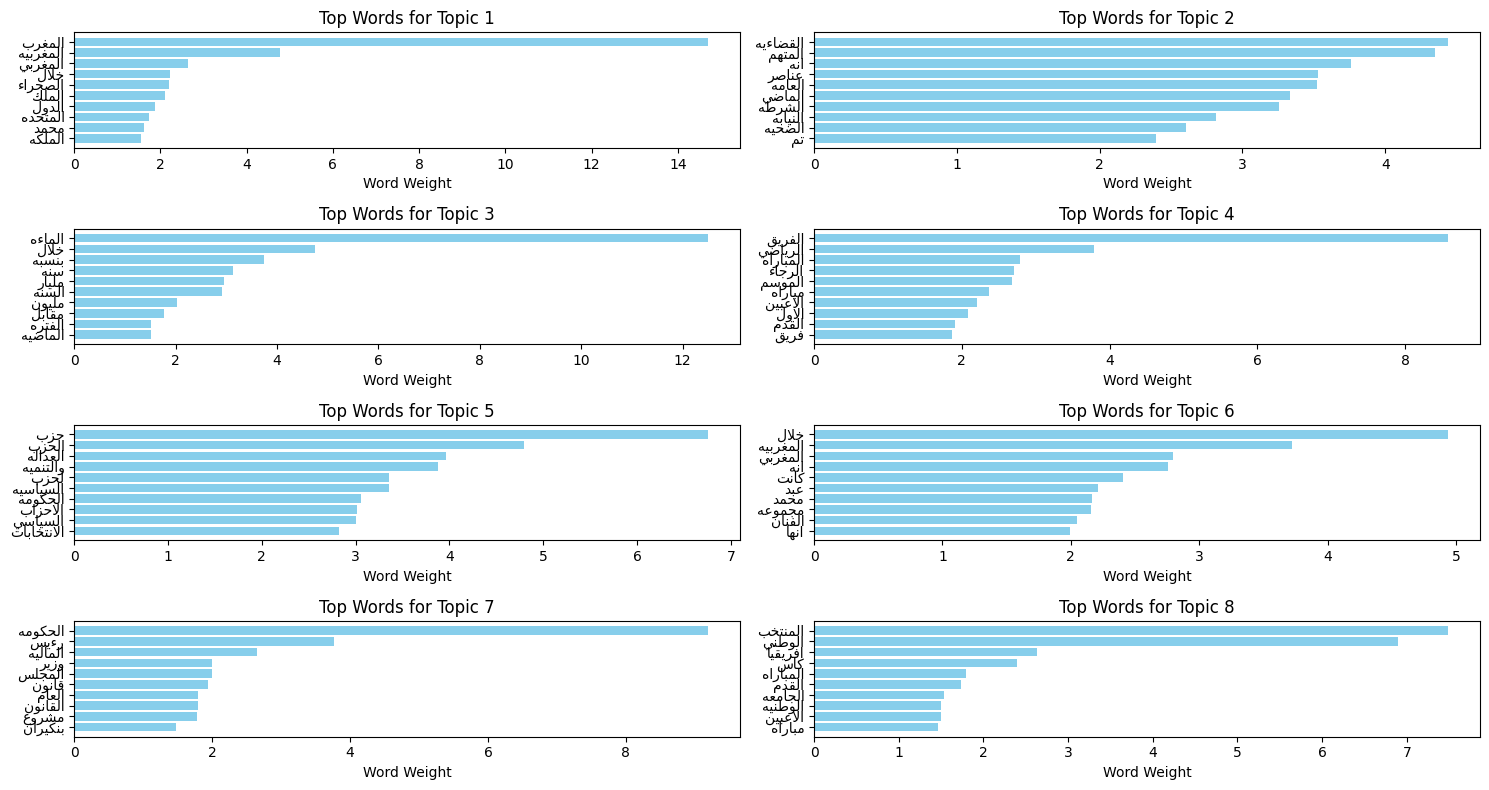

In [ ]:
#Plot the weight of top words in model
import matplotlib.pyplot as plt
from arabic_reshaper import arabic_reshaper
from bidi.algorithm import get_display

num_words = 10
feature_names = bow_vectorizer.get_feature_names_out()
components = loaded_nmf_model.components_
num_topics = len(components)
num_cols = 2
num_rows = (num_topics + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

for topic_idx, topic in enumerate(components):
    row_idx = topic_idx // num_cols
    col_idx = topic_idx % num_cols

    top_features_indices = topic.argsort()[-num_words:][::-1]
    top_features = [feature_names[i] for i in top_features_indices]
    top_features_weights = [topic[i] for i in top_features_indices]
    reshaped_text = [get_display(arabic_reshaper.reshape(word)) for word in top_features]

    axes[row_idx, col_idx].barh(reshaped_text, top_features_weights, color='skyblue')
    axes[row_idx, col_idx].set_xlabel('Word Weight')
    axes[row_idx, col_idx].set_title(f'Top Words for Topic {topic_idx + 1}')
    axes[row_idx, col_idx].invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
from IPython.display import display, HTML
import pandas as pd

num_words = 10
table = pd.DataFrame(columns=["Sample Text", "Dominant Topic", "Top Words"])
sample_data = df.sample(n=6)
sample_bow_representation = bow_vectorizer.transform(sample_data['processed_text'])
sample_topic_distribution = loaded_nmf_model.transform(sample_bow_representation)

# Find the dominant topic for each sample
dominant_topics = sample_topic_distribution.argmax(axis=1) + 1

for i, (text, topic_idx) in enumerate(zip(sample_data['processed_text'], dominant_topics)):
    top_features_indices = loaded_nmf_model.components_[topic_idx-1].argsort()[-num_words:][::-1]
    top_features = [bow_feature_names[j] for j in top_features_indices]
    top_words_str = ', '.join(top_features)
    table.loc[i] = [text, topic_idx, top_words_str]


display(HTML(table.to_html(index=False)))

Sample Text,Dominant Topic,Top Words
محمد اسليم اخبارنا المغربيه كشفت مصادر برلمانيه بمجلس النواب مقترح قانون تعديل الماده قانون الصحافه والنشر اعدته فرق الاغلبيه تمت احالته رءاسه المجلس ستقوم الاخري باحالته لجنه التعليم والثقافه والاتصال المناقشه الماده المقترحه لتعديل كانت تنص نسختها الاولي بانه يجب الخاضعين لمقتضيات القانون تاريخ نشره بالجريده الرسميه يلاءموا اوضاعهم متطلباته اقصاه سنه ستنتهي منتصف شهر غشت الجاري وهي الاجال اقترح تمديدها لسنه اضافيه تنتهي غشت وجدير بالذكر بنود قانون الصحافه والنشر الجديد خلفت استياء واسعا وسط مديري عد كبير المواقع الالكترونيه وصلت حد وصفه بالتراجعي عد كبير مديري المواقع الانتظام تنسيقيات وهيءات شرعت تنظيم محطات احتجاجيه مده,7,"الحكومه, رءيس, الماليه, وزير, المجلس, قانون, العام, القانون, مشروع, بنكيران"
وقع الدولي المغربي زهير فضال عقدا رسميا ليفانتي الاسباني يلعب الدولي المغربي الاخر نبيل الزهر واعلن النادي الاسباني انتداب فضال يحمل قميص بارما الايطالي هبوط النادي الايطالي الدرجه الرابعه بفعل مشاكله الماليه جعله لاعبا حرا وفضل فضال البالغ العمر سنه عرض ليفانتي عد العروض توصل ايطاليا وفرنسا ليعود بذلك الدوري الاسباني غادره عندما تلقي تكوينه اسبانيول ولعب فضال لانديه الفتح الرياضي وبارما وسينا وباليرمو بايطاليا علما انه لعب مباراه دوليه المنتخب الاولمبي المنتخب الوطني الاول,8,"المنتخب, الوطني, افريقيا, كاس, المباراه, القدم, الجامعه, الوطنيه, الاعبين, مباراه"
اخبارنا المغربيه احمد الهيلالي احتشد الاربعاء المءات المواطنين بساحه الود باكادير احتجاجا قرار ترامب باتخاد القدس عاصمه لاسراءيل وتعالت اصوات الاكاديرين الغاضبه رافعه شعارات منده لهذا القرار المخالف لكل المواثيق الدوليه الراميه تحقيق السلم والسلام بالمنطقه واقامه دوله فلسطينيه مستقله عاصمتها القدس ورد المحتجون شهارات قويه قبيل فلسطين فلسطين حاره ارحل ملعون ترامب ملعون الاقصي العيون بالروح بالدم نفديك قدس وغيرها الشعارات المناهضه لسياسه الامريكيه وطريقه تعاطيها وتعاملها القضيه الفلسطينيه والتحيز تبديه لكيان الاسراءيلي وشاركت الوقفه عده فعاليات جمعويه وثقافيه وحقوقيه وعد الاحزاب السياسيه المستنكره لقرار ترامب بنقل سفارته القدس واعتبارها عاصمه لاسراءيل وعلي خلفيه القرار صرح الفاعلين الحقوقين لموقع اخبارنا المغربيه الاعتراف بالقدس كعاصمه لاسراءيل بمثابه طعنه لكل الجهوذ المبدوله طرف المنظمات الدوليه والهيءات العالميه تشتغل استباب الامن بمنطقه الشرق الاوسط والحد الصراعات القاءمه بهذه الدول وترامب يعي جيدا خطوره اقدم فعواقب القرار ستنعكس فقط الشرق الاوسط الولايات المتحده الامريكيه ورعاياها بمختلف بقاع العالم سيصبحون مستهدفون وستفتح عليهم نار العمليات الارهابيه واشاد المتحدثون برساله الملك محمد السادس بعثها لرءيس الامريكي لثنيه قراره وصفوه بالمجنون واعتبره موقفا يكرس الاهميه يوليه جلالته لمسلسل السلم بالشرق الاوسط وكذ اتجاه فلسطين والقدس واكدوا انه موقف جد شجاع ظل الصمت المطبق واجهت الدول العربيه وزعماءها القرار والتي ابانت جبنها وخذلانها لقضيه العربيه الاولي,1,"المغرب, المغربيه, المغربي, خلال, الصحراء, الملك, الدول, المتحده, محمد, الملكه"
اصدرت الامانه العامه لحزب العداله والتنميه قرارا تاديبيا حق محمد الامين بوخبزه عضو المجلس الوطني وناءب الكاتب الاقليمي لحزب باقليم تطوان يقضي بطرده نهاءيا اقدامه تجاهل منهجيه الحزب المعتمده تقديم الترشيحات بالانتخابات التشريعيه المرتقب اجراءها السابع واعلنت الامانه العامه لحزب المصباح القرار بلاغ تءكد خلاله انتهاء العلاقه كانت تربط الامين بوخبزه الحزب جانب اعضاء اخرين وذلك خلفيه تقديم بوخبزه ترشيحه ضمن لاءحه مستقله رفقه اعضاء الحزب بالداءره الانتخابيه لتطوان وحسب البلاغ نشره الحزب موقع الالكتروني قرار الطرد حق الكاتب الاقليمي لحزب باقليم تطوان علقت خلال عضويته داخل حزب اخوان بنكيران جاء اجتماع عقدته الامانه العامه يوم تاكدت خلاله تقديم بوخبزه ترشيحه برسم الانتخابات التشريعيه المقبله ضمن لاءحه مستقله رفقه اعضاء الحزب بداءره تطوان وفي الوقت يستعد الحزب لدخول معركه الحمله الانتخابيه وجه اخوان بنكيران تحذيرا باقي الاعضاء والمناضلين دعم الاءحه المستقله ترشح بوخبزه متوعده يفعل بابعاده نهاءيا صفوف الحزب بالقول عضو سيقوم بدعم الاءحه المذكوره سيضع نفسه خارج الحزب وجهت الامانه العامه عبر بلاغها نداء عموم اعضاء الحزب بالداءره الانتخابيه لمدينه تطوان لدعم لاءحه الحزب جري التوافق بشانها خلال عمليه منح التزكيات تدعو الجميع احترام المنهجيه يعتمدها الحزب ترتيب لواءحه ستدخل غمار الاستحقاقات الانتخابيه المقبله,5,"حزب, الحزب, الع

In [ ]:
# Load the best_NMF_withTfidf model
import joblib
nmf_local_model_path="/content/drive/My Drive/topic_model/best_NMF_withTfidf.joblib"
loaded_nmf_model = joblib.load(nmf_local_model_path)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.matutils import Sparse2Corpus
from gensim.corpora import Dictionary
import gensim.corpora as corpora
from gensim.models import CoherenceModel

documents = df['processed_text'].tolist()

tokenized_text = [text.split() for text in df['processed_text']]
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

n_components = loaded_nmf_model.components_.shape[0]
topics = []
for i in range(n_components):
    topic = [tfidf_feature_names[i] for i in loaded_nmf_model.components_[i].argsort()[:-11:-1]]
    topics.append(topic)

texts = [text.split() for text in documents]
dictionary = corpora.Dictionary(texts)


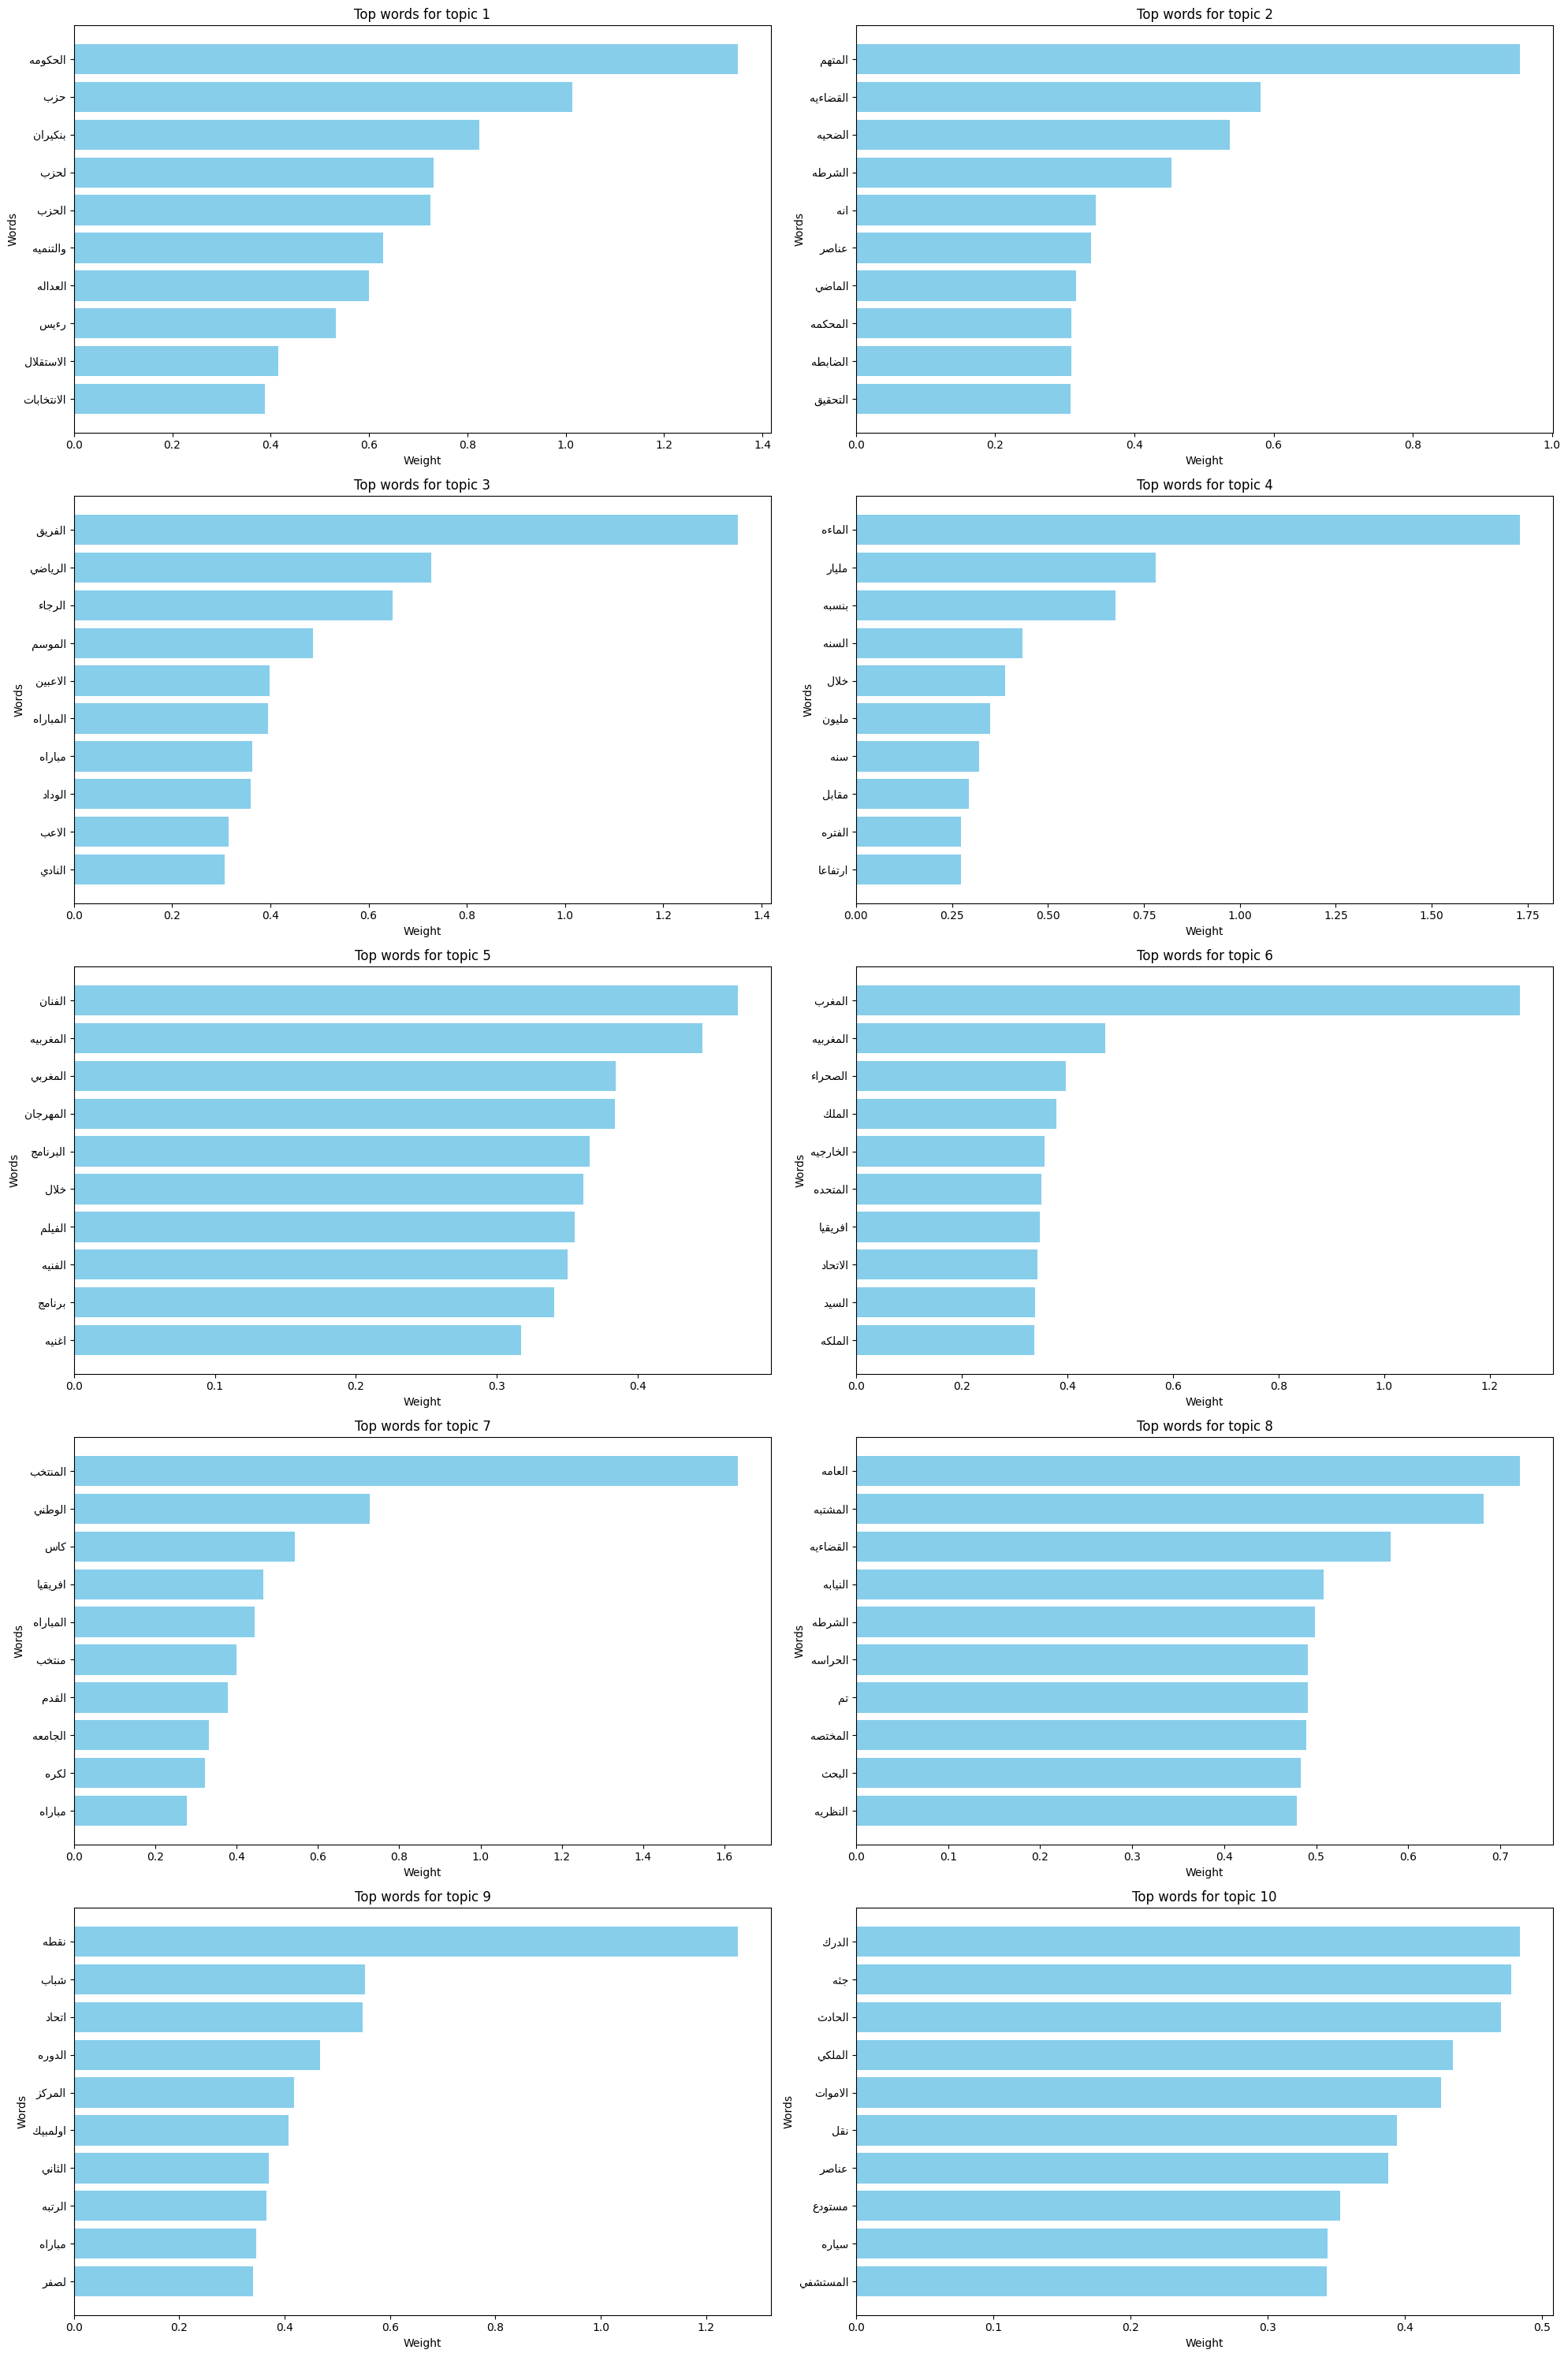

In [ ]:
#Plot the weight of top words in model
from arabic_reshaper import arabic_reshaper
from bidi.algorithm import get_display

num_words = 10
fig, axs = plt.subplots(5, 2, figsize=(20, 30))
# For each topic
for idx, topic in enumerate(loaded_nmf_model.components_):
    top_features_indices = topic.argsort()[-num_words:][::-1]
    top_features_weights = [topic[i] for i in top_features_indices]

    # Get the top words in the topic
    top_words = [tfidf_feature_names[i] for i in top_features_indices]
    reshaped_words = [get_display(arabic_reshaper.reshape(word)) for word in top_words]

    axs[idx // 2, idx % 2].barh(reshaped_words, top_features_weights, color='skyblue')
    axs[idx // 2, idx % 2].invert_yaxis()
    axs[idx // 2, idx % 2].set_title(f"Top words for topic {idx + 1}")
    axs[idx // 2, idx % 2].set_xlabel("Weight")
    axs[idx // 2, idx % 2].set_ylabel("Words")

plt.tight_layout()
plt.show()


In [ ]:
sample_data = df.sample(n=5)
documents = sample_data['processed_text'].tolist()
tfidf_sample = tfidf_vectorizer.transform(documents)
doc_topics = loaded_nmf_model.transform(tfidf_sample)
df_sample = pd.DataFrame(columns=["Sample Text", "Dominant Topic", "Top Words"])

for i, (doc, doc_topics) in enumerate(zip(documents, doc_topics)):
    dominant_topic = doc_topics.argmax() + 1
    top_features_indices = loaded_nmf_model.components_[dominant_topic-1].argsort()[-num_words:][::-1]
    top_features = [tfidf_feature_names[j] for j in top_features_indices]
    top_words_str = ', '.join(top_features)
    df_sample.loc[i] = [doc, dominant_topic, top_words_str]

display(HTML(df_sample.to_html(index=False)))


Sample Text,Dominant Topic,Top Words
اخبارنا المغربيه شهد مقر مجلس النواب مءخرا غزوا مسبوق لفءران الحشرات الامر دفع رشيد الطالبي العلمي رءيس المجلس الاعلان صفقه لاقتناء مواد سامه لاباده جحافل الفءران والحشرات وفق صحيفه الاخبار فقد فازت الشركات بالصفقه بمبلغ مليون لمطارده الفءران داخل مكاتب ومرات واقبيه البرلمان ابادتها افتاح الدوره البرلمانيه المقبله اعلن الطالبي وقت سابق فتح صفقات متعلقه بتجديد مكتبا اخر بقيمه مليون وقبلها العلمي اقتني سيارات فاره لاعضاء مكتب المجلس رغم الانتقادات اثيرت خلال السنوات الاخيره حول استعمال سيارات مجلس النواب والصراعات الشخصيه اندلعت نواب الرءيس حول استعمال سيارات البرلمان,1,"الحكومه, حزب, بنكيران, لحزب, الحزب, والتنميه, العداله, رءيس, الاستقلال, الانتخابات"
عمليه ترصد ومراقبه تمكنت عناصر الشرطه القضاءيه بمدينه اصيله ايقاف شخص ذوي السوابق العدليه حديث الافراج عنه السجن المحلي حاله تلبس بحيازه مجموعه قطع الشيرا ومبالغ ماليه متحصل عليها نشاطه المحظور المعني بالامر الملقب ب عمو والبالغ العمر سنه يتظاهر بمزاوله عمله كحارس لسيارات بوسط المدينه مستغلا لمد المدمنين بالمخد رات,8,"العامه, المشتبه, القضاءيه, النيابه, الشرطه, الحراسه, تم, المختصه, البحث, النظريه"
اوقفت مصالح الدرك بالمركز القضاءي سريه بيوكري اشخاص دو اري درايد وتكاض بسيدي بيبي ضواحي اشتوكه ايت باها اثر مداهمه مستودعي ثر داخلهما كميه المنوعات ليتم اخضاعهم لتدابير الحراسه النظريه بامر النيابه العامه المختصه وق رت الكميه المحجوزه بازيد كيلوغراما سنابل القنب الهندي الكيف ونحو كيلوغرامات مخدر الشيرا بالاضافه عد الاكياس المستعمله شحن المنوعات وفيما يجري البحث طرف العناصر الدركيه باشتوكه لوصول باقي الشركاء المحتملين العمليه يرج تخصيص المستودعين السرين لتخزين المنوعات ترويجها بالجمله,8,"العامه, المشتبه, القضاءيه, النيابه, الشرطه, الحراسه, تم, المختصه, البحث, النظريه"
بدعوه وزاره الثقافه والاعلام السعوديه وفي سياق التبادل الثقافي الاخوي والبناء الملكه المغربيه والملكه العربيه السعوديه الشقيقه وتوطيدا لحوار مثقفي البلدين والقراء البلد الشقيق يحل المغرب ضيف شرف بالمعرض الدولي لكتاب بالرياض ستنتظم فعالياته المقبل وبمناسبه التكريم يتوجه الثقافه المغربيه وبعد افتاح البرنامج المغربي طرف السيد وزير الثقافه محمد الامين الصبيحي والسيد وزير الاتصال مصطفي الخلفي بمعيه المسءولين السعودين الاشقاء ستنظم الوزاره ضمن فعاليات المعرض معرضا لكتاب يضم حوالي عنوان تشارك دارا مغربيه لنشر ستقدم مستجدات الاصدارات المغربيه القراء والمثقفين والاعلامين السعودين سيتم بموازاه المعرض تنظيم ندوات موضوعاتيه تمحور اولاها حول الفكر العربي الاسلامي المغرب المعاصر بمشاركه الاساتذه عبد السلام بنعبد العالي ومحمد المصباحي ومحمد جبرون والثانيه حول الخطاب النقدي الادبي المغرب رهانات التحديث بمشاركه الاساتذه محمد مفتاح وسعيد بنكراد وشرف الدين ماجدولين والثالثه حول الكتابه الرواءيه المغرب تاملات وتجارب بمشاركه الاساتذه الميلودي شغموم وجمال بوطيب وعبد الفتاح الحجمري قراءات شعريه ستنظم بنادي جده الادبي بمشاركه الشعراء عبد الكريم الطبال وصلاح الوديع وامينه المريني,6,"المغرب, المغربيه, الصحراء, الملك, الخارجيه, المتحده, افريقيا, الاتحاد, السيد, الملكه"
العلام رءيس المحكمه قال نشر ثقافه المساواه والتربيه قيمها خيار وطني ومسءوليه جماعيهاحتفاء باليوم العالمي لمراه اختارت المحكمه الابتداءيه بابن سليمان خلال رءيسها محمد العلام وكيل الملك محمد عامر تحتفل بكل النساء العاملات وتقديم هدايا لجلهن عباره ورود وقطع الشكولاته وتنقل الرءيس وكيل الملك عبر مكاتب المحكمه وقاما بتوزيع الورود والشكولاته موظفات المحكمه والقاضيات اثنيا الدور يقمن طيله ايام السنه منوهين بالمجهودات يقدمنها لمتقاضين ولم يستثن رءيس المحكمه وكيل الملك المحاميات بالمحكمه حضين بحقهن الورود والشكولاته يلتقط معهن صورا تذكاريه وكرما النساء حضرن يوم الاحتفال متابعه قضاياهن وحصلن الاخريات الورود والشكولاته الالتفاته رءيس المحكمه وكيل الملك لاقت اسحسانا قاضيات ومحاميات اكدن التعامل الراقي لمسءولين القضاءين يرتبط فقط بالاحتفال باليوم العالمي لمراه وانما يدخل اطار السلوك اليومي لتعامل لمسءولين يقدرون المراه بصفه وزميلاتهن العمل بصفه قال محمد العلام رءيس المحكمه الابتداءيه كلمه بالمناسبه اليوم العالمي لمراه يعتبر محطه لتوقف مليا الوضعيه الراهنه لمسيره ادماج المساواه الجنسين الاداره العموميه مذكرا بالمنجزات تحقت المجال ضمان تمثيليه وازنه لمراه مجال تدبير الشان العام والسعي تحقيق المناصفه نص عليها دستور الملكه واعتبر العلام النهوض بحقوق النساء ونشر ثقا

In [ ]:
# Load the LSA model
import joblib

lsa_model_path = "/content/drive/My Drive/topic_model/best_lsa_model.joblib"

loaded_lsa_model = joblib.load(lsa_model_path)

In [ ]:
tokenized_text = [text.split() for text in df['processed_text']]
id2word = Dictionary(tokenized_text)
corpus = [id2word.doc2bow(text) for text in tokenized_text]
# Show topics learned by the loaded LSA model
topics = loaded_lsa_model.show_topics(num_topics=-1, formatted=False)

# Print each topic
for topic_idx, topic in topics:
    print(f"Topic {topic_idx + 1}:")
    for term, weight in topic:
        print(f"- {term}: {weight:.4f}")
    print()


Topic 1:
- المغرب: 0.2938
- خلال: 0.2434
- انه: 0.1795
- المغربيه: 0.1751
- الحكومه: 0.1349
- سنه: 0.1272
- العام: 0.1243
- الماءه: 0.1222
- المغربي: 0.1197
- محمد: 0.1148

Topic 2:
- المغرب: -0.3034
- الماءه: -0.2588
- المتهم: 0.2183
- القضاءيه: 0.2156
- عناصر: 0.1744
- الشرطه: 0.1608
- انه: 0.1583
- العامه: 0.1543
- الماضي: 0.1420
- النيابه: 0.1383

Topic 3:
- الماءه: -0.5969
- الحكومه: 0.2354
- خلال: -0.1924
- بنسبه: -0.1781
- حزب: 0.1775
- سنه: -0.1576
- مليار: -0.1439
- السنه: -0.1397
- الحزب: 0.1192
- رءيس: 0.1089

Topic 4:
- الفريق: -0.3863
- الحكومه: 0.2503
- الرياضي: -0.2006
- المباراه: -0.1860
- المنتخب: -0.1729
- حزب: 0.1556
- مباراه: -0.1547
- الاعبين: -0.1443
- القدم: -0.1341
- الموسم: -0.1299

Topic 5:
- المغرب: -0.5051
- الحكومه: 0.3009
- الماءه: 0.2940
- حزب: 0.2123
- المغربيه: -0.1885
- الفريق: 0.1866
- الحزب: 0.1447
- العداله: 0.1220
- الوطني: 0.1191
- والتنميه: 0.1176

Topic 6:
- المغرب: -0.4420
- خلال: 0.1945
- »،: 0.1855
- ”،: 0.1546
- الفريق: -0.1400
- الفنان: 0.1

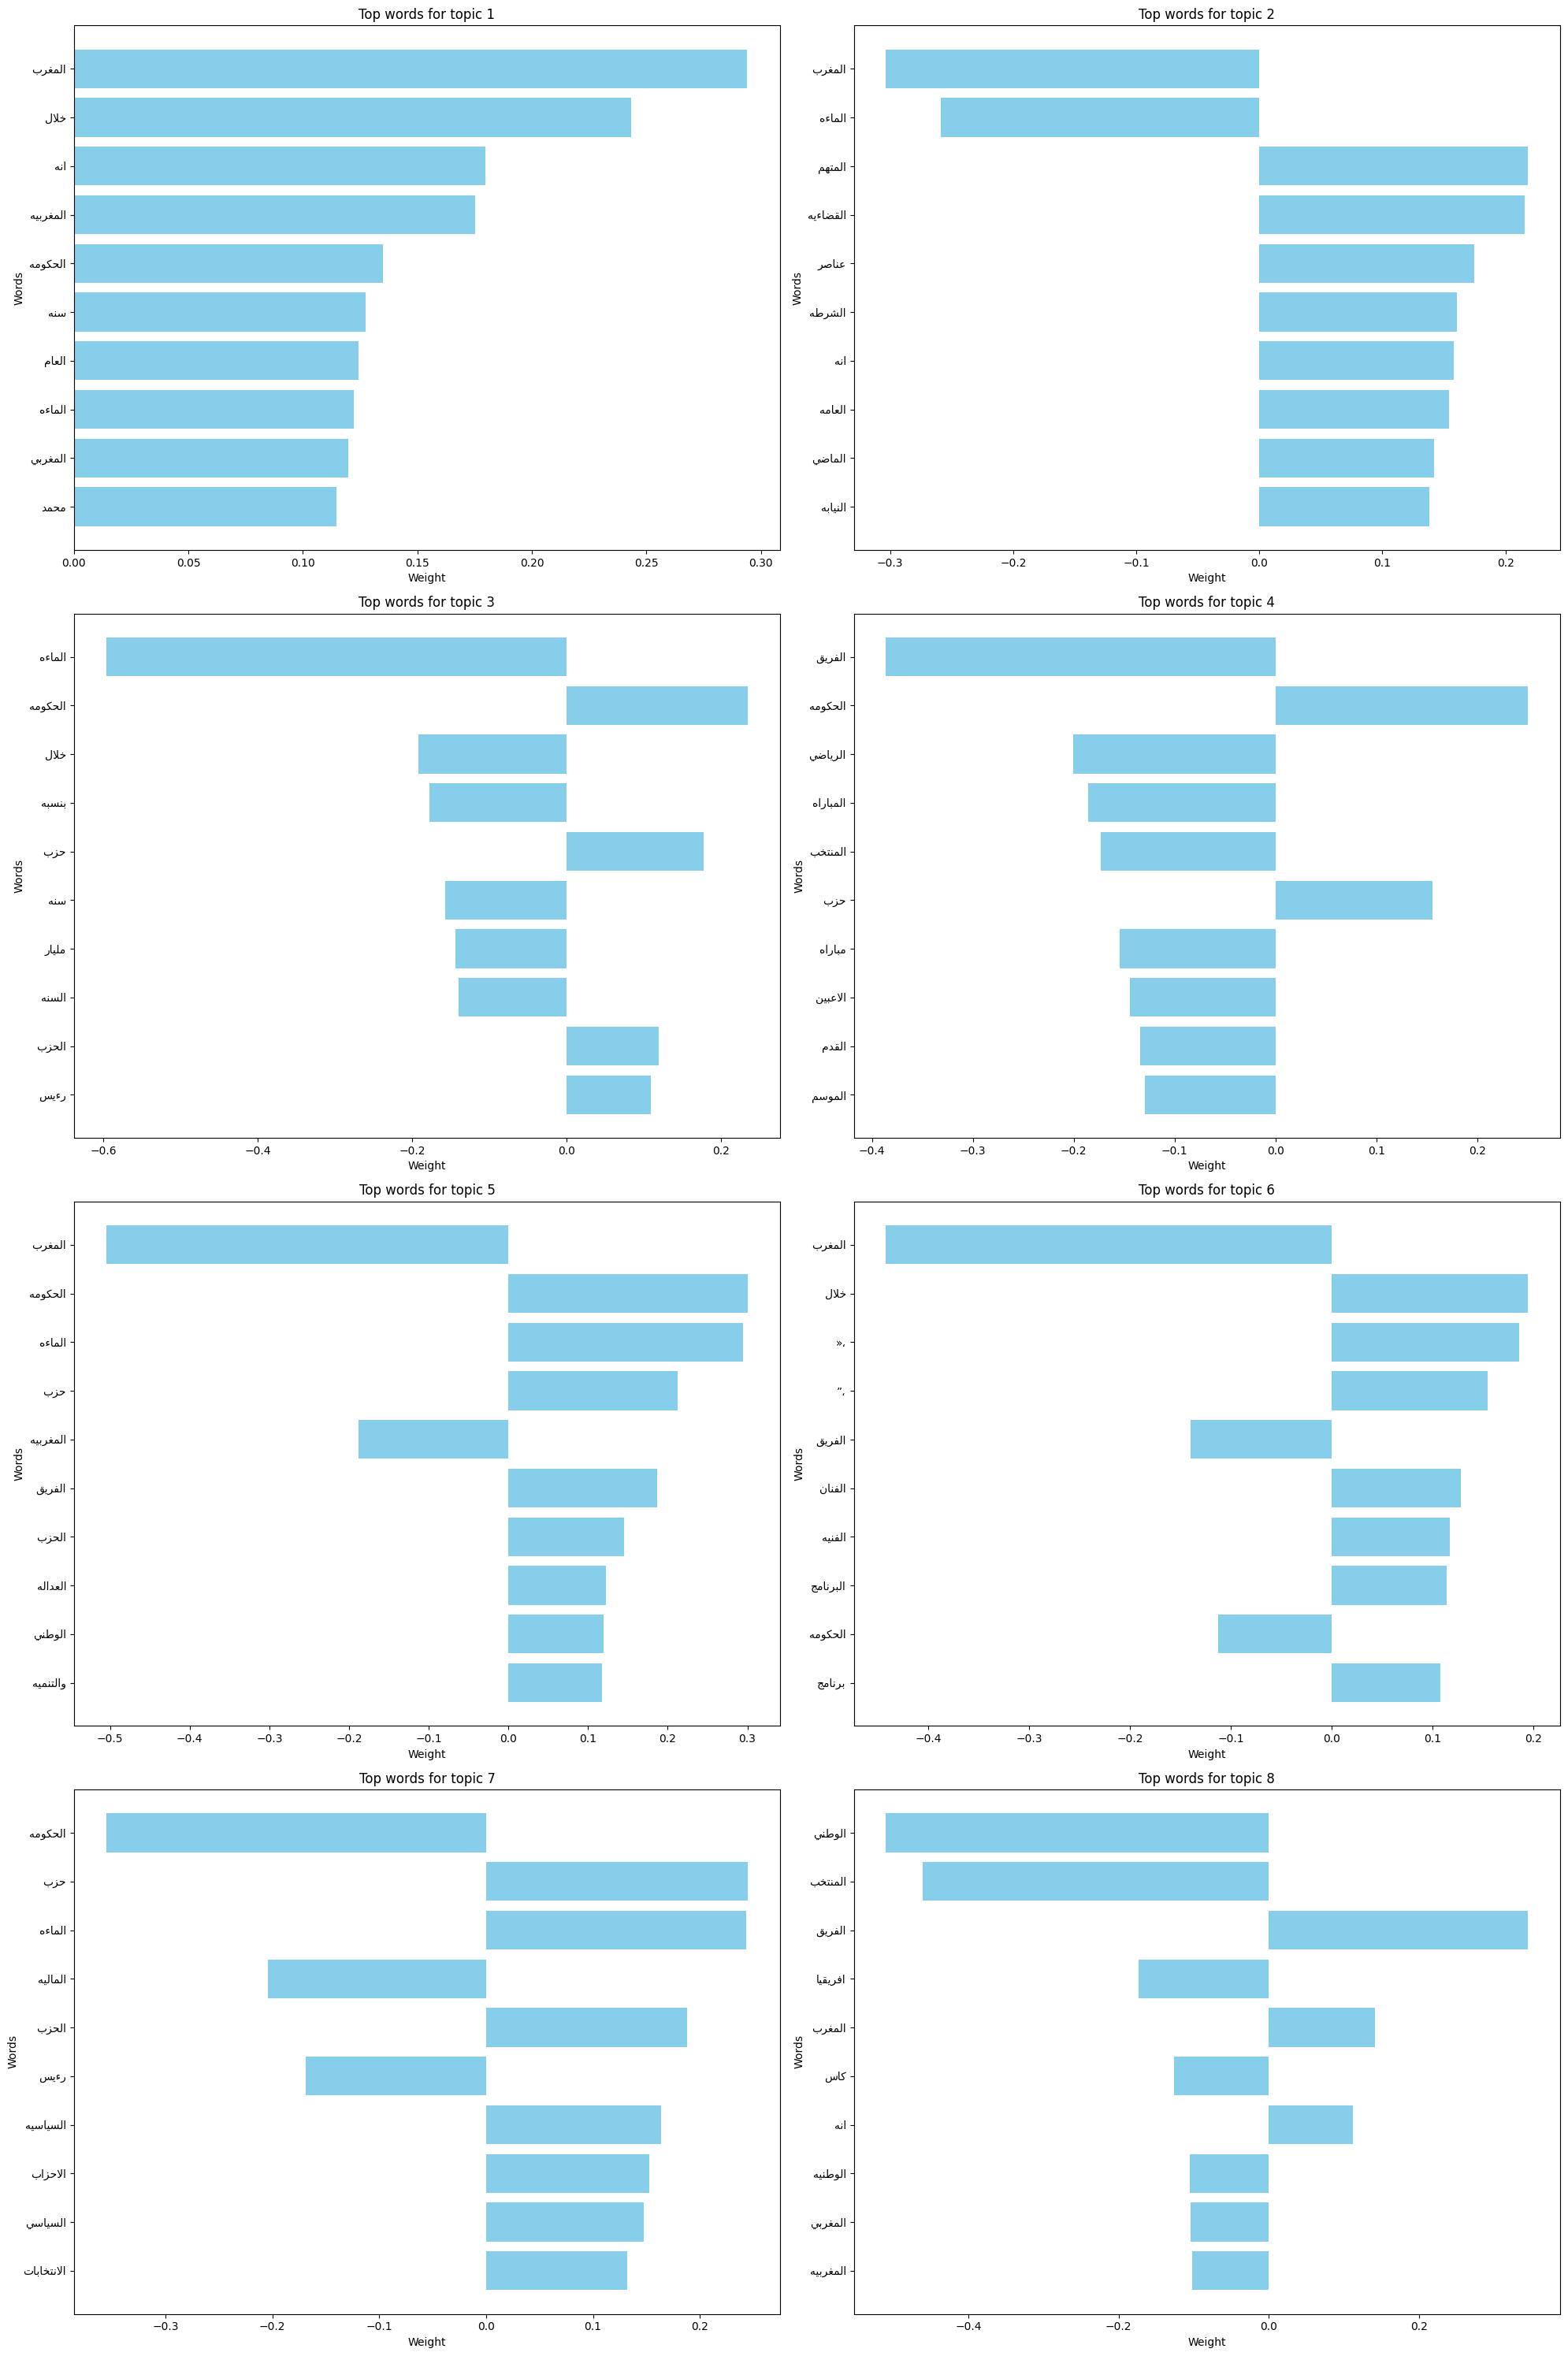

In [ ]:
#Plot the weight of top words in model
import matplotlib.pyplot as plt
from arabic_reshaper import arabic_reshaper
from bidi.algorithm import get_display

num_words = 10
fig, axs = plt.subplots(4, 2, figsize=(20, 30))

for idx, topic in enumerate(loaded_lsa_model.show_topics(num_topics=-1, formatted=False)):
    top_words = [word for word, _ in topic[1]]
    top_weights = [weight for _, weight in topic[1]]
    reshaped_words = [get_display(arabic_reshaper.reshape(word)) for word in top_words]
    axs[idx // 2, idx % 2].barh(reshaped_words, top_weights, color='skyblue')
    axs[idx // 2, idx % 2].invert_yaxis()
    axs[idx // 2, idx % 2].set_title(f"Top words for topic {idx + 1}")
    axs[idx // 2, idx % 2].set_xlabel("Weight")
    axs[idx // 2, idx % 2].set_ylabel("Words")

plt.tight_layout()
plt.show()


In [ ]:
sample_data = df.sample(n=5)

for i, doc in sample_data.iterrows():
    tokenized_doc = doc['processed_text'].split()
    bow_doc = id2word.doc2bow(tokenized_doc)
    doc_topics = loaded_lsa_model[bow_doc]

    total_weight = sum(max(0, weight) for _, weight in doc_topics)
    normalized_topics = [(topic, max(0, weight) / total_weight) for topic, weight in doc_topics if weight > 0]

    print(f"Document {i+1} Topics:")
    for topic, weight in normalized_topics:
        print(f"Topic {topic}: {weight*100:.2f}%")


Document 6761 Topics:
Topic 0: 82.87%
Topic 6: 7.20%
Topic 7: 9.94%
Document 15 Topics:
Topic 0: 38.43%
Topic 5: 56.24%
Topic 6: 5.33%
Document 10626 Topics:
Topic 0: 43.27%
Topic 1: 16.94%
Topic 2: 9.18%
Topic 4: 22.93%
Topic 6: 7.68%
Document 1499 Topics:
Topic 0: 62.53%
Topic 2: 20.08%
Topic 3: 4.01%
Topic 5: 9.76%
Topic 6: 3.62%
Document 3944 Topics:
Topic 0: 45.16%
Topic 1: 42.29%
Topic 3: 12.54%


In [ ]:
sample_data['processed_text'].iloc[4]

'تعرض مستشار جماعي بسلا اليوم الثلاثاء اعتداء بواسطه السلاح الابيض مجهولين استدعي نقله المستشفي حاله حرجه السلطات المحليه بسلا واضاف المصدر ذاته المستشار الجماعي قاسم النعيمي ناءب رءيسه مقاطعه تابريكت ومفوض مجال التعمير تعرض اليوم بالقرب منزله بسلا لاعتداء مجهولين استدعي نقله الي مستشفي ابن سينا بالرباط لتلقي العلاجات وقد باشرت المصالح الامنيه عمليه البحث المعتدين تم فتح تحقيق لمعرفه ملابسات الحادث'

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

